In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'similarity_matrix_across_combined_dhpc_expo'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
from itertools import product

In [6]:
expo_animals =  'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4','dhpc37'
post_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
post_hiatus_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
all_animals = 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4','dhpc37'

In [7]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

In [8]:
sessions = 'expo','post','post_hiatus' #exclude expo because did not register with that session
comparison_labels='CS1','CS2','CS3','CS4'
#only going to analyze .5s and 1s bins here to save time.
bins = ['05s','1s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16]


In [9]:
CR_comparisons = 'expopost','expopost_hiatus','postpost_hiatus' #exclude expo session, since did not cellreg this

In [10]:
#get patterns of cells registered across all 3 sessions
for tb in bins:
    for sess in sessions:
        exec("cellreg_patterns_%s_%s_reg_w_all = dict(zip(all_animals, [ut.load_variable('patterns_evs_reg_%s_%s_all',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                      for ani in all_animals]))"%(tb,sess,tb,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))

In [11]:
min_cells_reg_all = 0
for key in cellreg_patterns_1s_expo_reg_w_all:
    min_cells_reg_all=min_cells_reg_all+np.shape(cellreg_patterns_1s_expo_reg_w_all[key])[-1]
print "cells registered across all sessions =",min_cells_reg_all

cells registered across all sessions = 503


In [12]:
#combine cells and patterns across animals
#combined for each tb should = 120xall cells
for sess in sessions:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            for odor,trial in zip(comparison_labels,[1,2,3,4]):
                exec("combined_patterns_%s_%s_%s_%s=[]"%(tb,sess,t,odor))
                exec("combined_patterns_%s_%s_%s_%s = np.concatenate(([cellreg_patterns_%s_%s_reg_w_all[ani][t][labels_%s[ani]==trial]\
                  for ani in all_animals]),axis=1)"%(tb,sess,t,odor,tb,sess,sess))


In [25]:
%%time
#this will get correlations for each animal individually (...will it, though?)
# downsample trials of post and hiatus to match expo
odors= 'CS1','CS2','CS3','CS4'
t = range(16)
pattern_ids_1s_expo =  ['1s_%s_%s_expo'%(tt,odor) for tt, odor in product(t,odors)]
pattern_ids_1s_post = ['1s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]
pattern_ids_1s_post_hiatus = ['1s_%s_%s_post_hiatus'%(tt,odor) for tt, odor in product(t,odors)]

all_patterns_1s_expo = [eval('combined_patterns_1s_expo_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_expo, all_patterns_1s_expo)
across_tb_1s_res_expo=corrmat_distr
print 'expo DONE!',

all_patterns_1s_post = [eval('combined_patterns_1s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
# need to downsample to 15 trials to match expo
all_patterns_1s_post = [sublist[:15] for sublist in all_patterns_1s_post]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_post, all_patterns_1s_post)
across_tb_1s_res_post=corrmat_distr
print 'post DONE!',

all_patterns_1s_post_hiatus = [eval('combined_patterns_1s_post_hiatus_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
# need to downsample to 15 trials to match expo
all_patterns_1s_post_hiatus = [sublist[:15] for sublist in all_patterns_1s_post_hiatus]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_post_hiatus, all_patterns_1s_post_hiatus)
across_tb_1s_res_post_hiatus=corrmat_distr
print 'post_hiatus DONE!',

## DO NO TRY THE BELOW: doesn't iterate over tt
#tb='1s'
#t=range(16)
#for sess in 'expo',:
#        exec("all_patterns_%s_%s = [combined_patterns_%s_%s_%s_%s for tt,odor in product(t,odors)]"%(tb,sess,tb,sess,tt,odor))
#        corrmat_distr, corrmat = ut.compute_similarity_matrix(eval("pattern_ids_%s_%s"%(tb,sess)), eval("all_patterns_%s_%s"%(tb,sess)))
#        exec("across_tb_%s_res_%s=corrmat_distr"%(tb,sess))
#        print '%s DONE!'%sess,

post DONE! post_hiatus DONE!CPU times: user 1min 30s, sys: 224 ms, total: 1min 30s
Wall time: 1min 30s



In [26]:
%%time
#get correlations across sessions
odors= 'CS1','CS2','CS3','CS4'
t = range(16)

#combine ids of each session pair
pattern_ids_1s_expopost  =  np.append(pattern_ids_1s_expo,pattern_ids_1s_post,axis=0)   
pattern_ids_1s_expopost_hiatus  =  np.append(pattern_ids_1s_expo,pattern_ids_1s_post_hiatus,axis=0)   
pattern_ids_1s_postpost_hiatus  =  np.append(pattern_ids_1s_post,pattern_ids_1s_post_hiatus,axis=0)   

#cmobine patterns of each session pair
all_patterns_1s_expopost = np.append(all_patterns_1s_expo,all_patterns_1s_post,axis=0)   
all_patterns_1s_expopost_hiatus = np.append(all_patterns_1s_expo,all_patterns_1s_post_hiatus,axis=0)  
all_patterns_1s_postpost_hiatus = np.append(all_patterns_1s_post,all_patterns_1s_post_hiatus,axis=0)  

#run the correlation
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_expopost, all_patterns_1s_expopost)
across_tb_res_1s_expopost=corrmat_distr
print 'expo vs post DONE!',

corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_expopost_hiatus, all_patterns_1s_expopost_hiatus)
across_tb_res_1s_expopost_hiatus=corrmat_distr
print 'expo vs post_hiatus DONE!',

corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_postpost_hiatus, all_patterns_1s_postpost_hiatus)
across_tb_res_1s_postpost_hiatus=corrmat_distr
print 'post vs post_hiatus DONE!',

expo vs post DONE! expo vs post_hiatus DONE! post vs post_hiatus DONE!CPU times: user 9min 17s, sys: 1.48 s, total: 9min 19s
Wall time: 9min 18s



In [28]:
%%time
#get within-session correlations for 0.5s time bins
t = range(32)
pattern_ids_05s_expo =  ['05s_%s_%s_expo'%(tt,odor) for tt, odor in product(t,odors)]
pattern_ids_05s_post = ['05s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]
pattern_ids_05s_post_hiatus = ['05s_%s_%s_post_hiatus'%(tt,odor) for tt, odor in product(t,odors)]

all_patterns_05s_expo = [eval('combined_patterns_05s_expo_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_expo, all_patterns_05s_expo)
across_tb_05s_res_expo=corrmat_distr
print 'expo DONE!',

all_patterns_05s_post = [eval('combined_patterns_05s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
all_patterns_05s_post = [sublist[:15] for sublist in all_patterns_05s_post]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_post, all_patterns_05s_post)
across_tb_05s_res_post=corrmat_distr
print 'post DONE!',

all_patterns_05s_post_hiatus = [eval('combined_patterns_05s_post_hiatus_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
all_patterns_05s_post_hiatus = [sublist[:15] for sublist in all_patterns_05s_post_hiatus]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_post_hiatus, all_patterns_05s_post_hiatus)
across_tb_05s_res_post_hiatus=corrmat_distr
print 'post_hiatus DONE!',

expo DONE! post DONE! post_hiatus DONE!CPU times: user 9min 15s, sys: 2.85 s, total: 9min 18s
Wall time: 9min 17s



In [29]:
%%time
#get correlations across sessions for 0.5s time bins
odors= 'CS1','CS2','CS3','CS4'
t = range(32)

#combine ids of each session pair
pattern_ids_05s_expopost  =  np.append(pattern_ids_05s_expo,pattern_ids_05s_post,axis=0)   
pattern_ids_05s_expopost_hiatus  =  np.append(pattern_ids_05s_expo,pattern_ids_05s_post_hiatus,axis=0)   
pattern_ids_05s_postpost_hiatus  =  np.append(pattern_ids_05s_post,pattern_ids_05s_post_hiatus,axis=0)   

#cmobine patterns of each session pair
all_patterns_05s_expopost = np.append(all_patterns_05s_expo,all_patterns_05s_post,axis=0)   
all_patterns_05s_expopost_hiatus = np.append(all_patterns_05s_expo,all_patterns_05s_post_hiatus,axis=0)  
all_patterns_05s_postpost_hiatus = np.append(all_patterns_05s_post,all_patterns_05s_post_hiatus,axis=0)  

#run the correlation
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_expopost, all_patterns_05s_expopost)
across_tb_res_05s_expopost=corrmat_distr
print 'expopost DONE!',

corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_expopost_hiatus, all_patterns_05s_expopost_hiatus)
across_tb_res_05s_expopost_hiatus=corrmat_distr
print 'expopost DONE!',

corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_postpost_hiatus, all_patterns_05s_postpost_hiatus)
across_tb_res_05s_postpost_hiatus=corrmat_distr
print 'expopost DONE!',

expopost DONE! expopost DONE! expopost DONE!CPU times: user 36min 54s, sys: 6.34 s, total: 37min
Wall time: 36min 57s



In [30]:
#make matrix of all comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess in sessions:
            for odor in odors:
                exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor,tb1))
                exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("matrix_%s_%s_%s_%s"%(tb,sess,odor,tb1)).insert(tb2,eval("np.mean(across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))
                    eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,tb1)).insert(tb2,eval("across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))

In [32]:
#make matrix of all comparisons across tbs for across-session data
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess,split in zip(CR_comparisons,[4,4,4]): #this is what's diff from above. split is for separating session labels via slice index
            for odor in odors:
                exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor,tb1))
                exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("matrix_%s_%s_%s_%s"%(tb,sess,odor,tb1)).insert(tb2,eval("np.mean(across_tb_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,sess[split:],tb,tb2,odor,sess[:split])))
                    eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,tb1)).insert(tb2,eval("across_tb_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,sess[split:],tb,tb2,odor,sess[:split])))

In [33]:
#make matrix of all across-odor comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for tb1 in range(bin_ranges[i]):
            for sess in sessions:
                    exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor_comp,tb1))
                    exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor_comp,tb1))
                    for tb2 in range(bin_ranges[i]):
                        #get mean values across all animals
                        eval("matrix_%s_%s_%s_%s"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("np.mean(across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))
                        eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))

In [34]:
#make matrix of all across-odor comparisons across tbs for across-session correlations
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for tb1 in range(bin_ranges[i]):
            for sess,split in zip(CR_comparisons,[4,4,4]): #this is what's diff from above. split is for separating session labels via slice index
                    exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor_comp,tb1))
                    exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor_comp,tb1))
                    for tb2 in range(bin_ranges[i]):
                        #get mean values across all animals
                        eval("matrix_%s_%s_%s_%s"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("np.mean(across_tb_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess[split:],tb,tb2,odor_comp.split('v')[-1],sess[:split])))
                        eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("across_tb_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess[split:],tb,tb2,odor_comp.split('v')[-1],sess[:split])))

In [35]:
#get standard deviation and standard error for individual trial vs trial comparisons
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for t in range(bin_ranges[i]):
            for sess in sessions:
                exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [36]:
#get standard deviation and standard error for individual trial vs trial comparisons for across-session data
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for t in range(bin_ranges[i]):
            for sess in CR_comparisons:
                exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [37]:
for tb,i in zip(bins,range(len(bins))):
    for sess in sessions:
        for trial in ['CS1','CS2','CS3','CS4','CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']:
            exec("big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

In [38]:
for tb,i in zip(bins,range(len(bins))):
    for sess in CR_comparisons:
        for trial in ['CS1','CS2','CS3','CS4','CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']:
            exec("big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

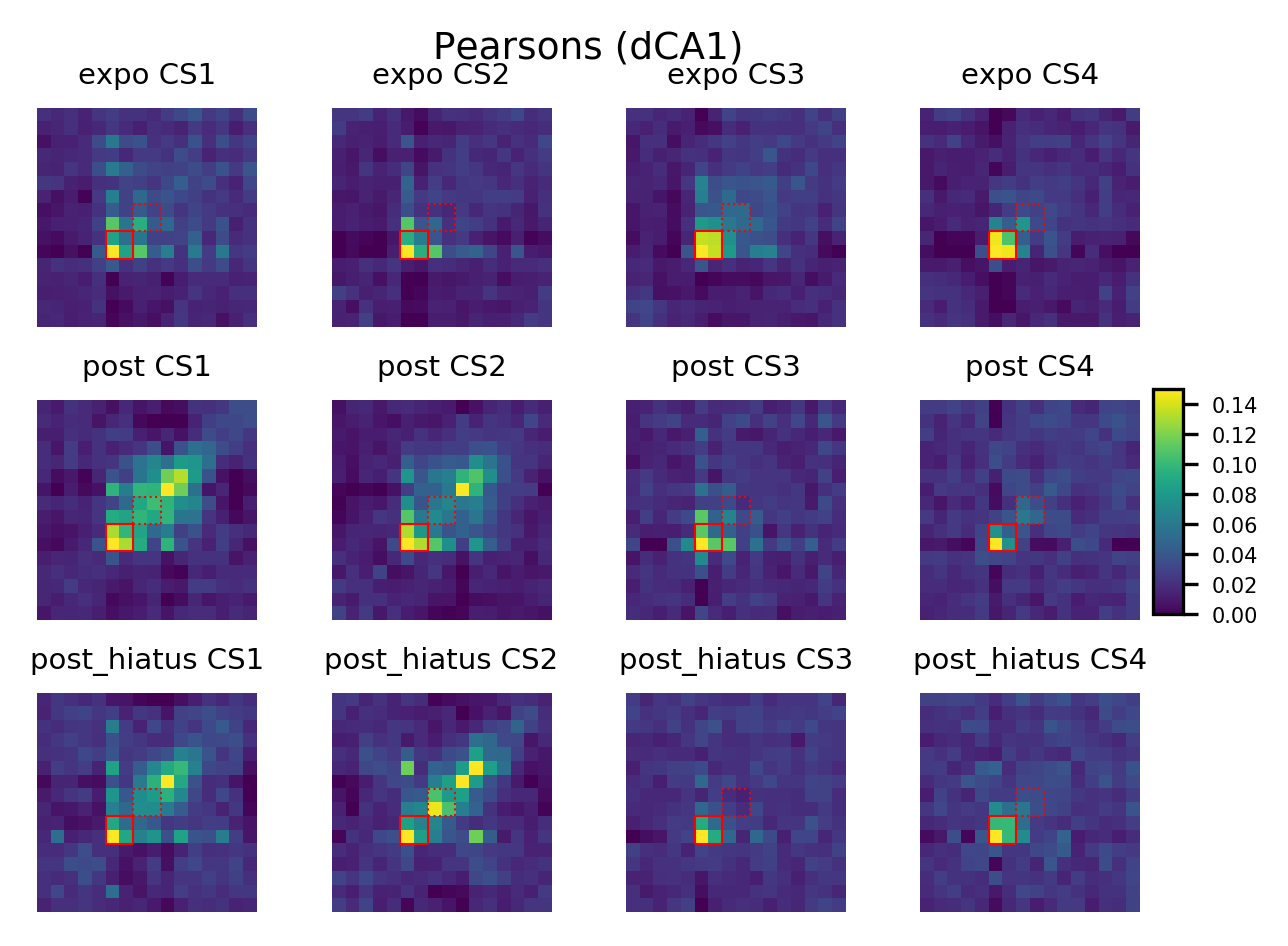

In [72]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,3))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+" "+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

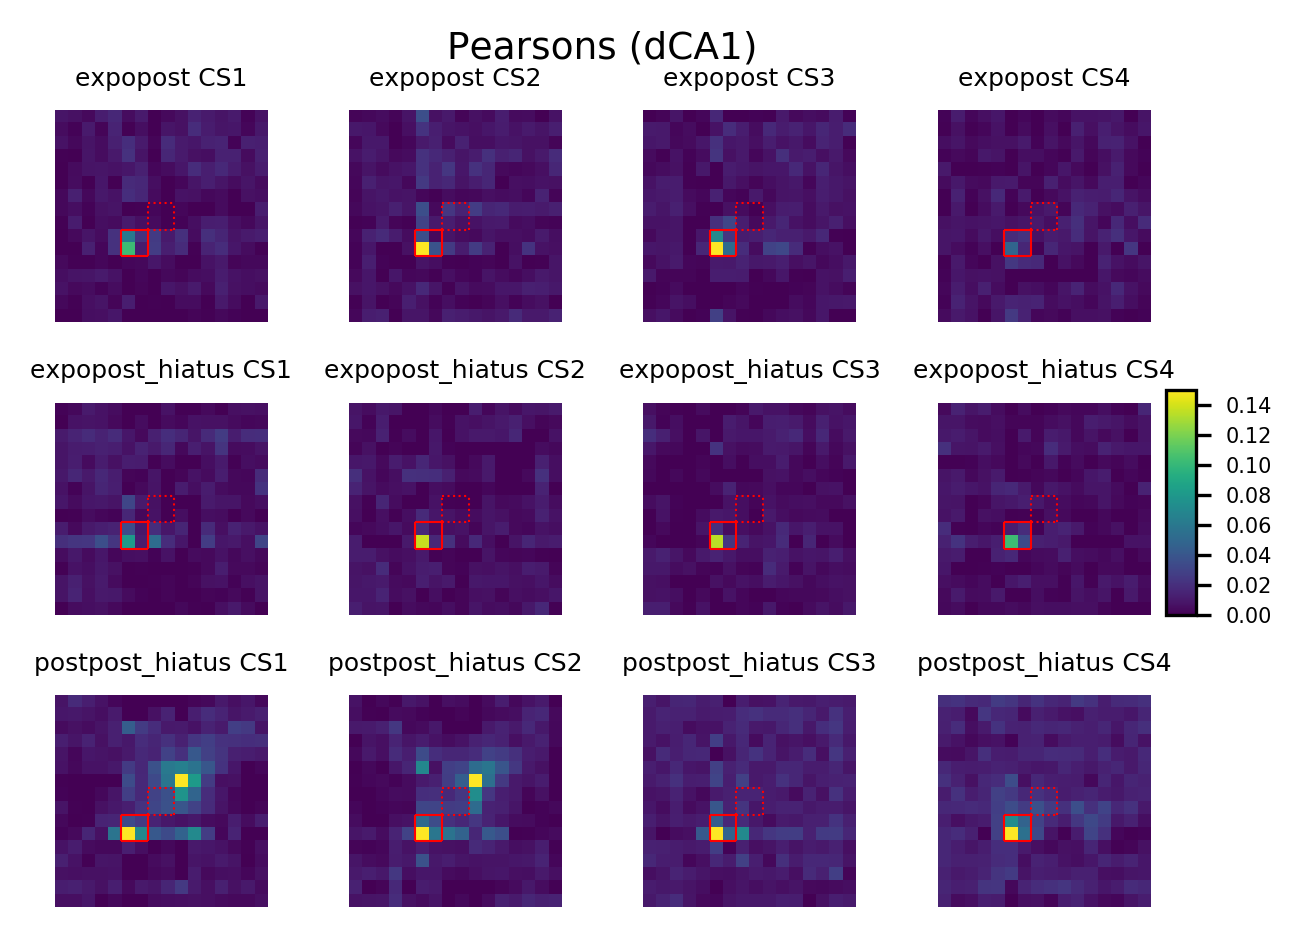

In [73]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,3))
for sess,r in zip(CR_comparisons,range(len(CR_comparisons))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+" "+trial,fontsize=6)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

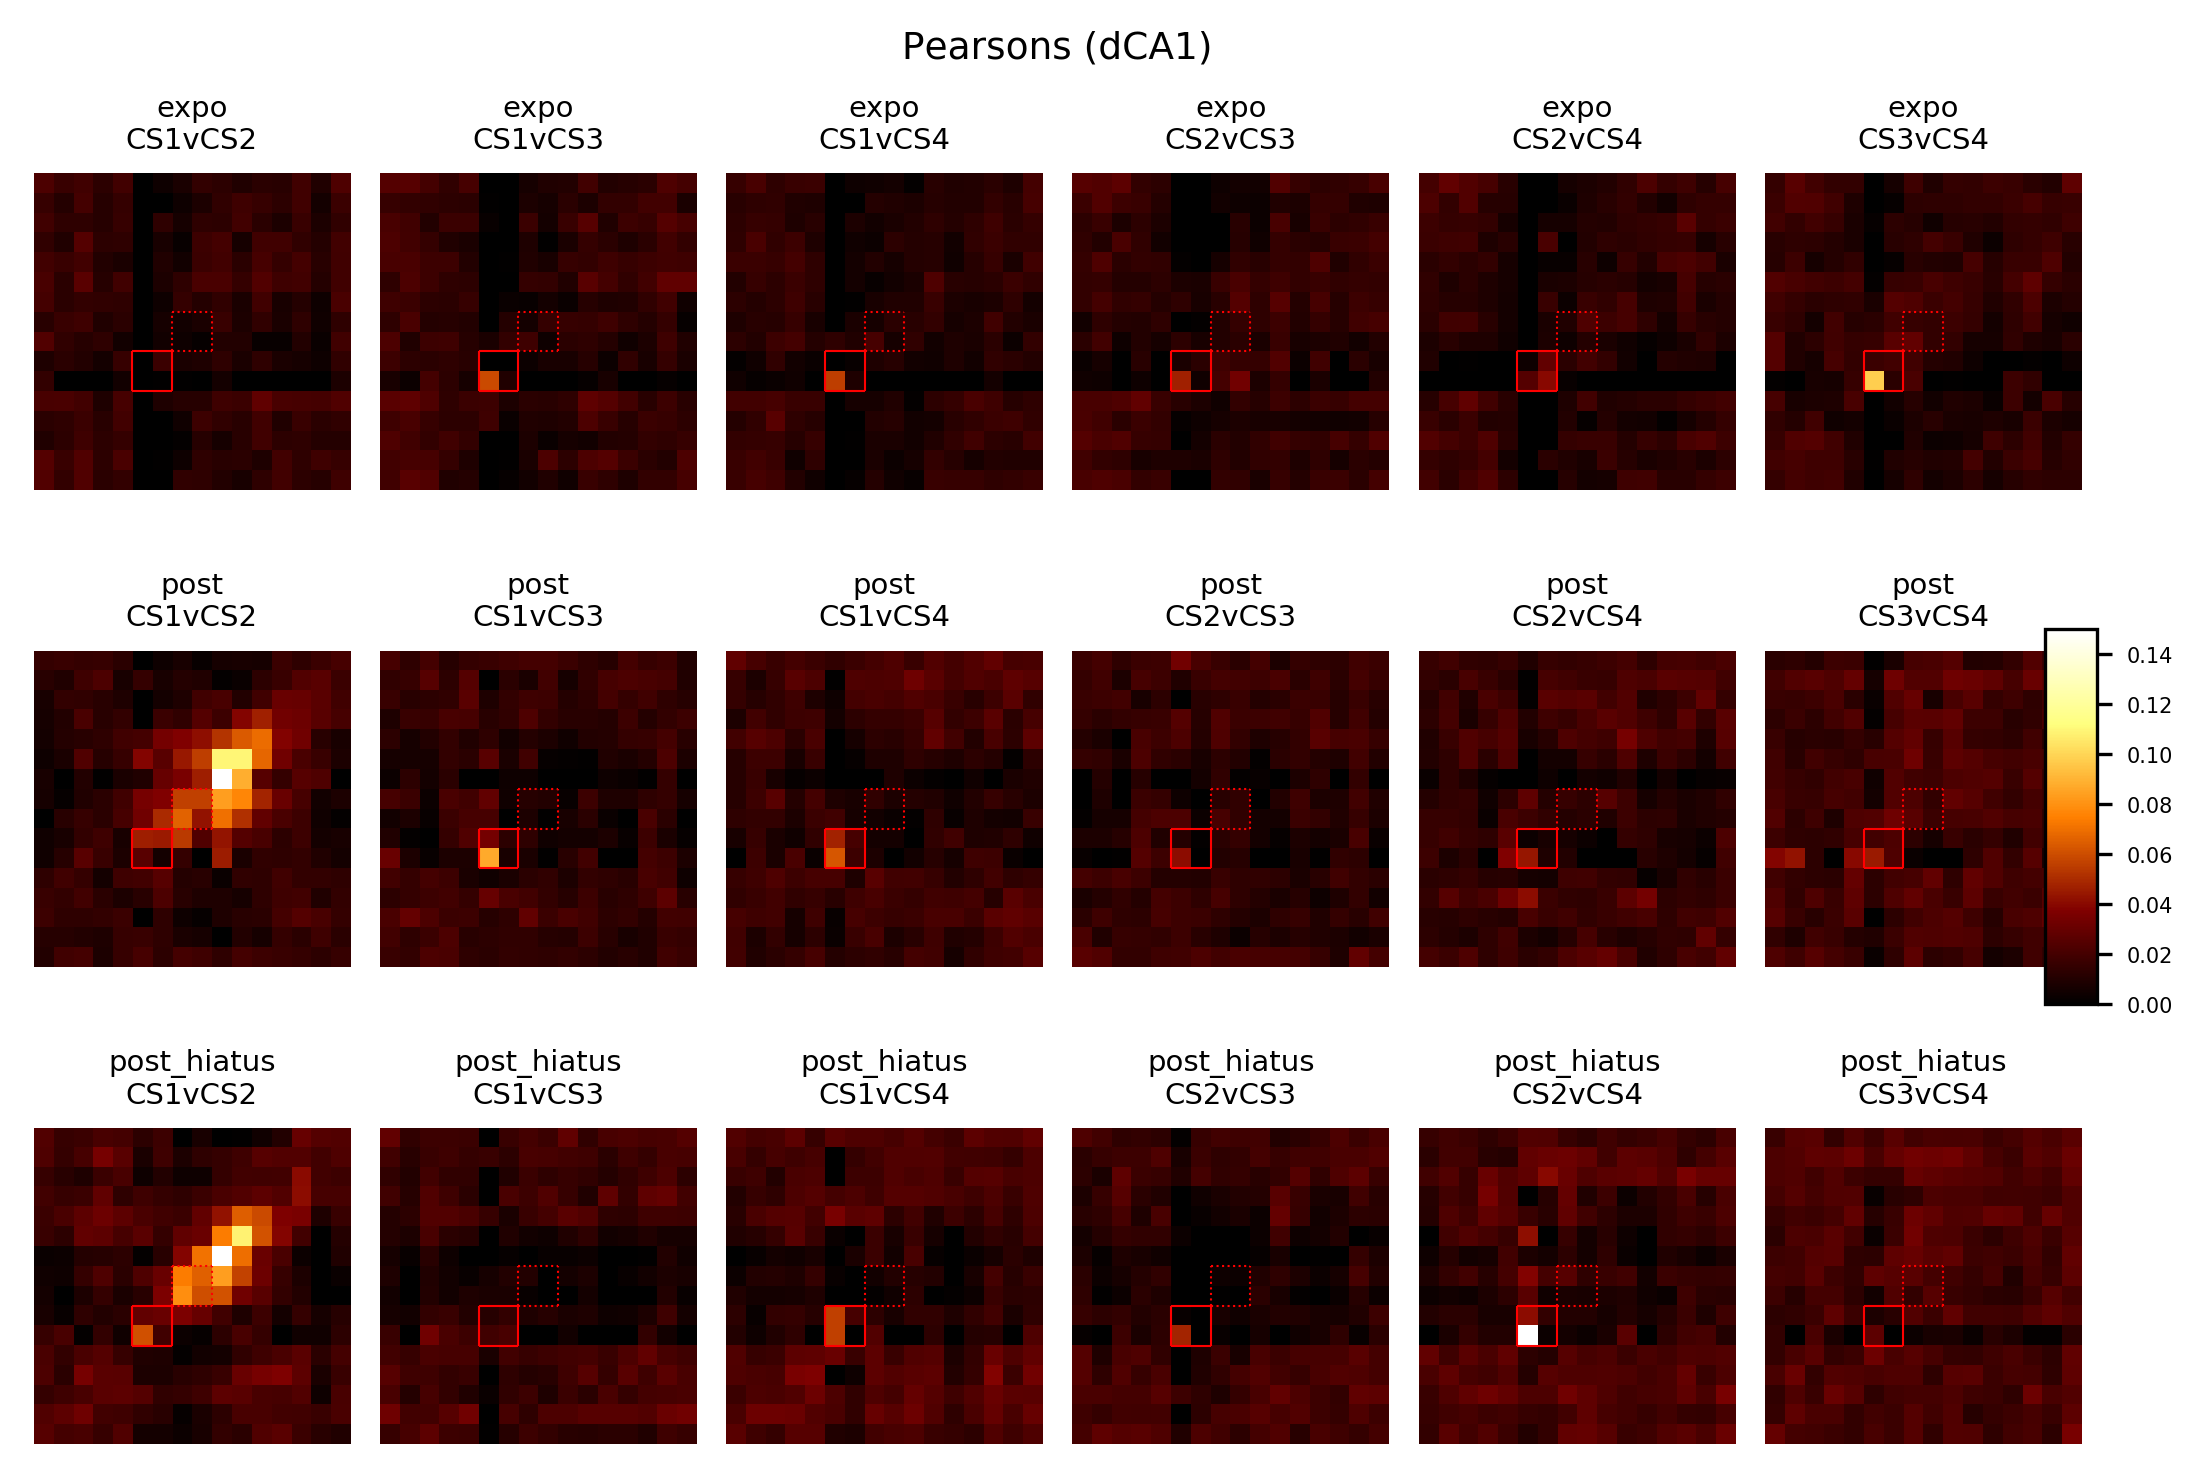

In [74]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,6,figsize=(7,5))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4'],[0,1,2,3,4,5]):
        im=axs[r][c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15,cmap='afmhot')
        axs[r][c].set_title(sess+"\n"+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

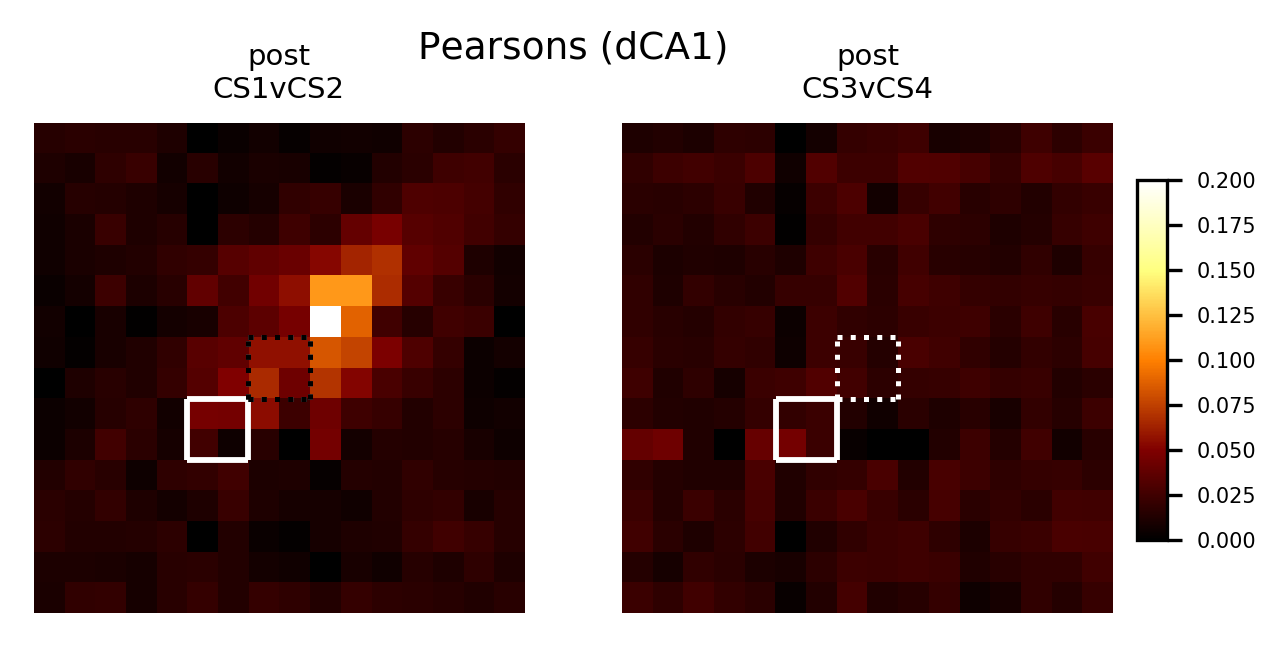

In [75]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(1,2,figsize=(4,2))
sess='post'
r=0
for trial,c in zip(['CS1vCS2','CS3vCS4'],[0,1]):
        im=axs[c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=0.0, vmax=0.2,cmap='afmhot')
        axs[c].set_title(sess+"\n"+trial,fontsize=7)
        axs[c].vlines(4.5,4.5,6.5,color='w',linewidth=1.4)
        axs[c].hlines(4.5,4.5,6.5,color='w',linewidth=1.4)
        axs[c].vlines(6.5,4.5,6.5,color='w',linewidth=1.4)
        axs[c].hlines(6.5,4.5,6.5,color='w',linewidth=1.4)
        axs[c].vlines(6.5,6.5,8.5,color='w',linestyle=':',linewidth=1.2)
        axs[c].hlines(6.5,6.5,8.5,color='w',linestyle=':',linewidth=1.2)
        axs[c].vlines(8.5,6.5,8.5,color='w',linestyle=':',linewidth=1.2)
        axs[c].hlines(8.5,6.5,8.5,color='w',linestyle=':',linewidth=1.2)
        axs[0].vlines(6.5,6.5,8.5,color='k',linestyle=':',linewidth=1.2)
        axs[0].hlines(6.5,6.5,8.5,color='k',linestyle=':',linewidth=1.2)
        axs[0].vlines(8.5,6.5,8.5,color='k',linestyle=':',linewidth=1.2)
        axs[0].hlines(8.5,6.5,8.5,color='k',linestyle=':',linewidth=1.2)
        pt.remove_axes(axs[c])
pl.suptitle('Pearsons (dCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.16, 0.025, 0.6])
pl.colorbar(im,cax=cax)

fig.tight_layout()
fig.savefig("../figures/%s_Po_hm.pdf"%NOTEBOOK_NAME)

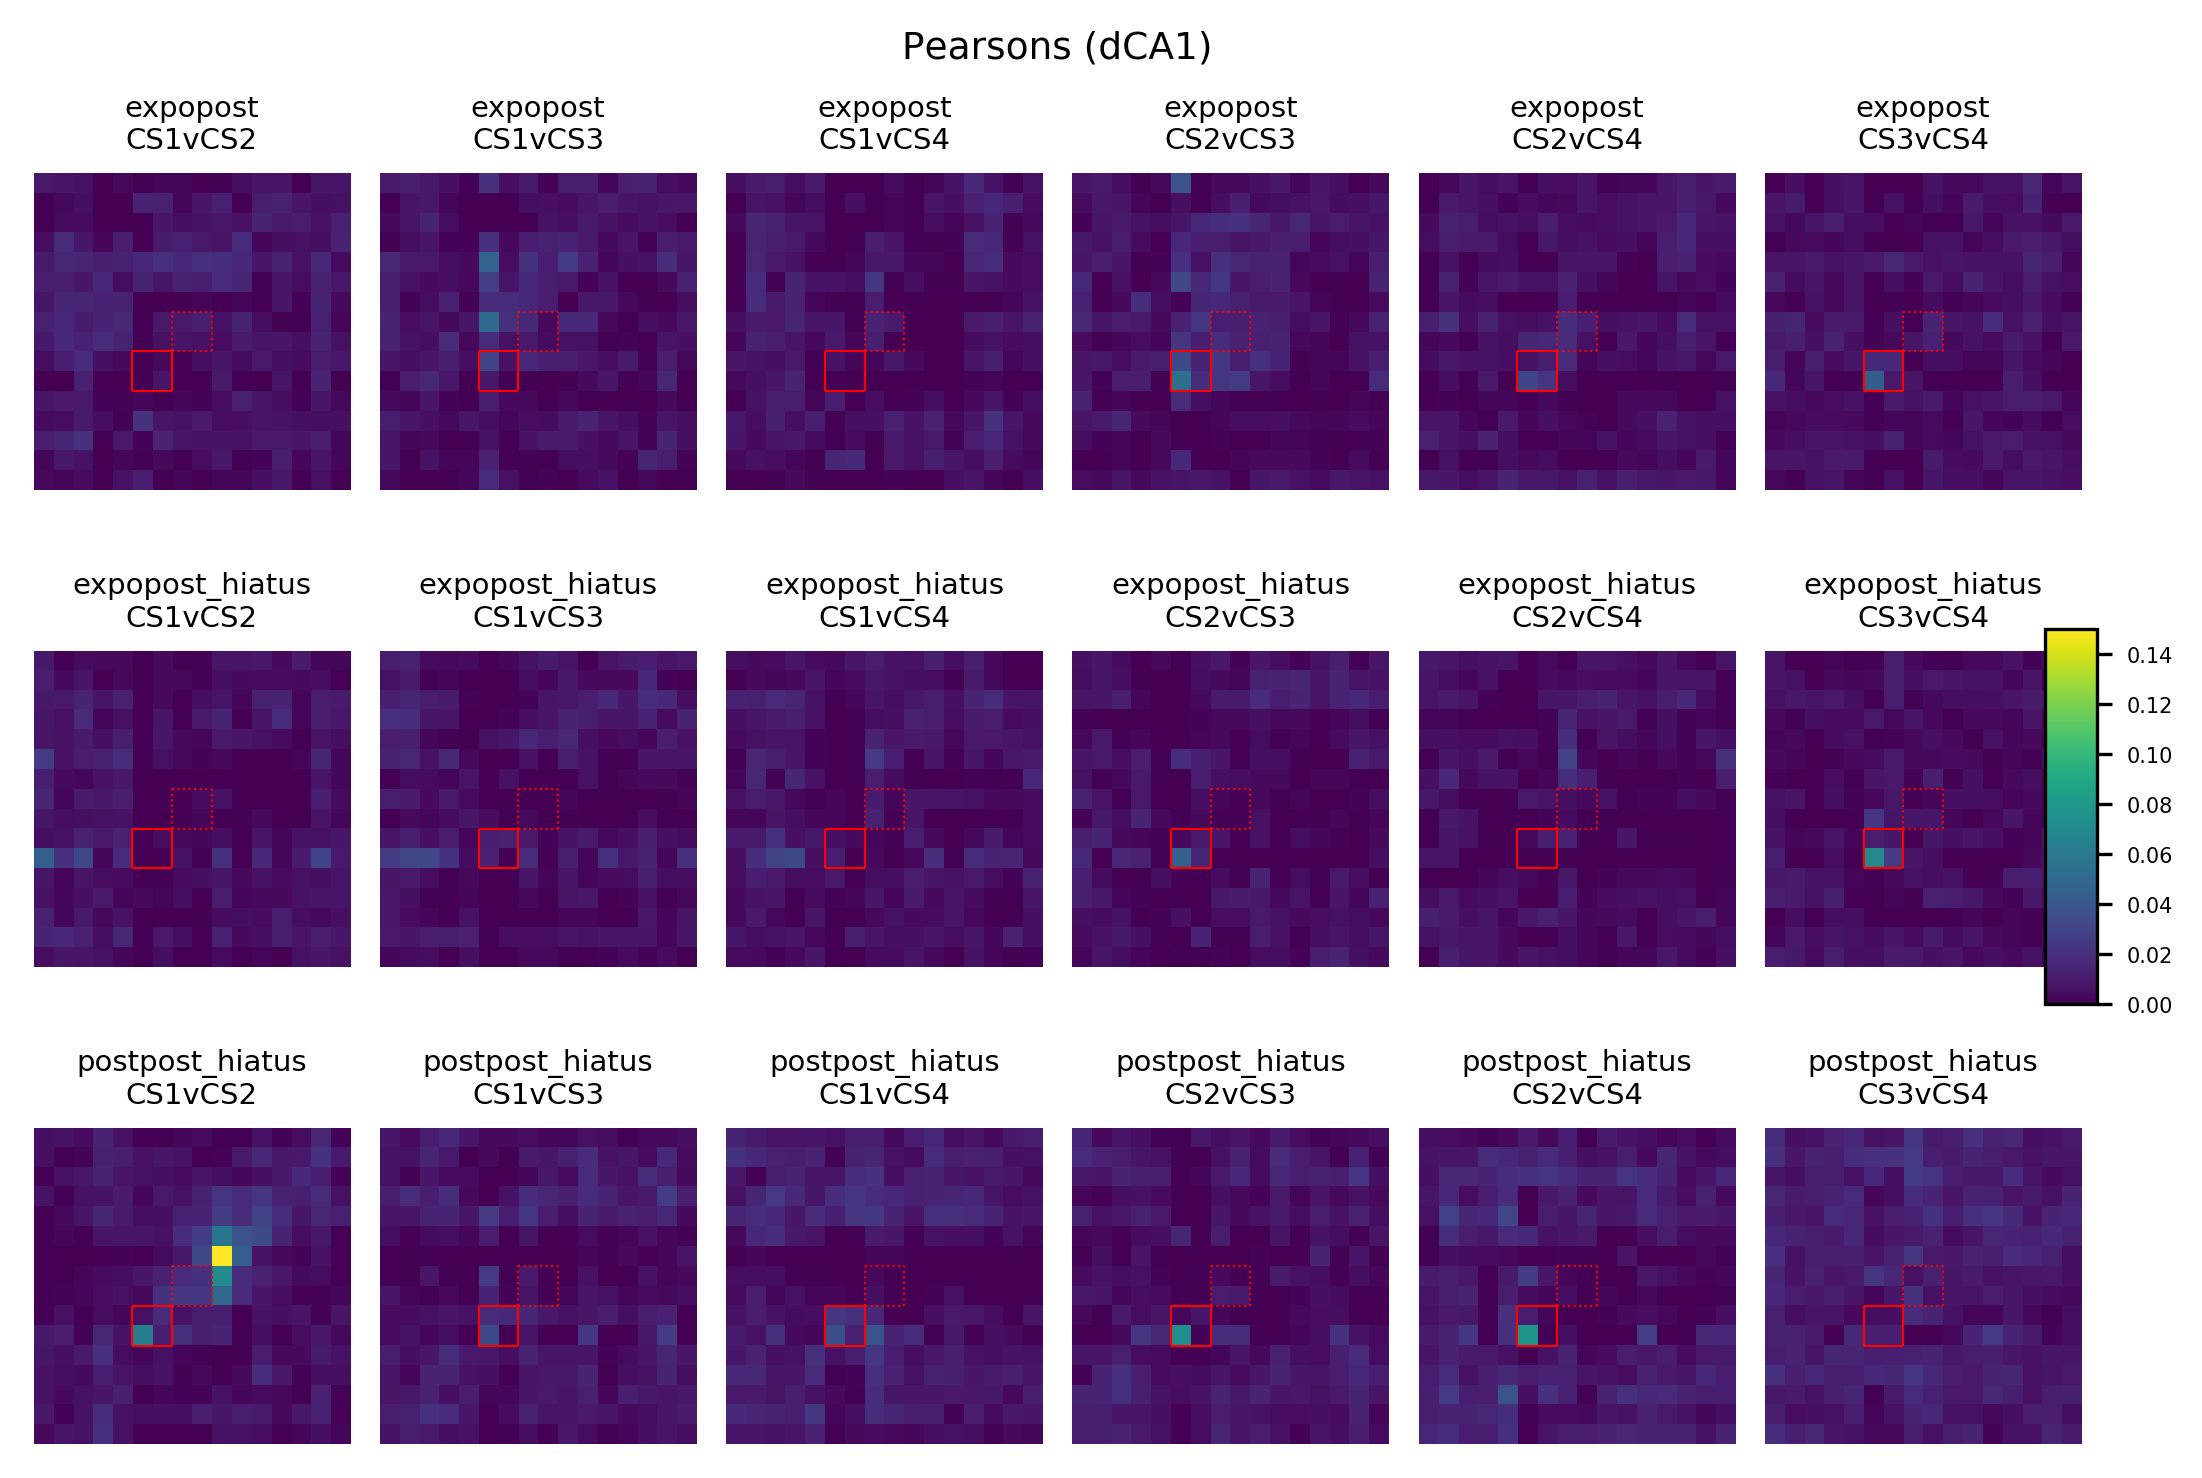

In [76]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,6,figsize=(7,5))
for sess,r in zip(CR_comparisons,range(len(CR_comparisons))):
    for trial,c in zip(['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4'],[0,1,2,3,4,5]):
        im=axs[r][c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+"\n"+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1)',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

In [77]:
#import seaborn as sns
#%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
#
#fig, ax = pl.subplots(1, 1, figsize=(4, 2))
#
#pairs_to_plot = [('tb14_CSp_expo', 'tb14_CSp_expo'),
#                 ('tb14_CSp_expo', 'tb15_CSp_expo'),
#                 ('tb14_CSp_expo', 'tb1_CSp_expo'),
#                 ('tb14_CSm_expo', 'tb14_CSm_expo'),
#                 ('tb14_CSm_expo', 'tb15_CSm_expo'),
#                 ('tb14_CSm_expo', 'tb1_CSm_expo')]
#values = [across_tb_res_expo[p] for p in pairs_to_plot]
#avg_values = [np.mean(across_tb_res_expo[p]) for p in pairs_to_plot]
##seaborn for individual points with jitter
#sns.set(style="white", color_codes=False)
#sns.stripplot(data=values,jitter=True,edgecolor=None,size=2,alpha=.5)
#sns.despine()
#
##colors = np.repeat(['b', 'r', 'silver', 'grey', 'y'], len(values)/5).tolist()
## pt.plot_violins(values, ax=ax, colors=colors)
##positions = range(len(values))
##[ax.plot([p]*len(v), v, 'o', mew=0, ms=2, color=c, alpha=0.5, zorder=0) for p, v, c in zip(positions, values, colors)]
#
#pt.plot_bars(values, ax=ax, stderr=True)
##pl.bar(range(len(avg_values)),avg_values)
## [b.set_color(c) for b, c in zip(bp['boxes'], colors)]
## [b.set_color(c) for b, c in zip(bp['whiskers'], np.repeat(colors, 2))]
## [b.set_color(c) for b, c in zip(bp['caps'], np.repeat(colors, 2))]
#
#ax.set_xticks(range(len(values)))
#ax.set_xticklabels(['%s\n%s'%(p[0][2:8], p[1][2:8]) for p in pairs_to_plot], fontsize=5)
##ax.set_xlabel('expo       Post               Ext1               Ext2           Renew', fontsize=7)
##ax.set_ylim(-0.05, 0.5)
#ax.set_ylabel("Pattern similarity")
#pt.nicer_plot(ax)
#
#fig.tight_layout()
#
#ax.set_title('Pearsons correlation')
##fig.savefig("../img/similarity_CSp_dhpc_JSB.jpg")

### just do correlations on the last 10 trials

#don't need to do this because when do across-session below, are also doing within session
%%time
#For mid trials, take beginning with trial 8)
for tb in bins:
    for sess in sessions: 
        exec("mid_patterns_%s_%s=[]"%(tb,sess))
        for x in range(len(eval("all_patterns_%s_%s"%(tb,sess)))):
            exec("mid_patterns_%s_%s.append(all_patterns_%s_%s[x][8:23])"%(tb,sess,tb,sess))
        
        corrmat_distr, corrmat = ut.compute_similarity_matrix(eval("pattern_ids_%s_%s"%(tb,sess)),eval("mid_patterns_%s_%s"%(tb,sess)))
        exec("mid_res_%s_%s=corrmat_distr"%(tb,sess))
        print '%s DONE!'%sess,

In [45]:
%%time
#For mid trials, take beginning with trial 5)
for tb in bins:
    for sess in CR_comparisons: 
        exec("mid_patterns_%s_%s=[]"%(tb,sess))
        for x in range(len(eval("all_patterns_%s_%s"%(tb,sess)))):
            exec("mid_patterns_%s_%s.append(all_patterns_%s_%s[x][5:15])"%(tb,sess,tb,sess))
        
        corrmat_distr, corrmat = ut.compute_similarity_matrix(eval("pattern_ids_%s_%s"%(tb,sess)),eval("mid_patterns_%s_%s"%(tb,sess)))
        exec("mid_res_%s_%s=corrmat_distr"%(tb,sess))
        print '%s DONE!'%sess,

expopost DONE! expopost_hiatus DONE! postpost_hiatus DONE! expopost DONE! expopost_hiatus DONE! postpost_hiatus DONE!CPU times: user 21min 20s, sys: 5.32 s, total: 21min 25s
Wall time: 21min 23s



In [46]:
#make matrix of all comparisons across tbs within a session
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess,w_sess in zip(['expopost','postpost_hiatus','postpost_hiatus'],['expo','post','post_hiatus']):
            for odor in odors:
                exec("mid_matrix_%s_%s_%s_%s = []"%(tb,w_sess,odor,tb1))
                exec("mid_matrix_%s_%s_%s_%s_all = []"%(tb,w_sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("mid_matrix_%s_%s_%s_%s"%(tb,w_sess,odor,tb1)).insert(tb2,eval("np.mean(mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,w_sess,tb,tb2,odor,w_sess)))
                    eval("mid_matrix_%s_%s_%s_%s_all"%(tb,w_sess,odor,tb1)).insert(tb2,eval("mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,w_sess,tb,tb2,odor,w_sess)))

In [47]:
#make matrix of all comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess,split in zip(CR_comparisons,[4,4,4]): #this is what's diff from above. split is for separating session labels via slice index
            for odor in odors:
                exec("mid_matrix_%s_%s_%s_%s = []"%(tb,sess,odor,tb1))
                exec("mid_matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("mid_matrix_%s_%s_%s_%s"%(tb,sess,odor,tb1)).insert(tb2,eval("np.mean(mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,sess[split:],tb,tb2,odor,sess[:split])))
                    eval("mid_matrix_%s_%s_%s_%s_all"%(tb,sess,odor,tb1)).insert(tb2,eval("mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,sess[split:],tb,tb2,odor,sess[:split])))

In [48]:
#make matrix of all odor comparisons across tbs within session
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for tb1 in range(bin_ranges[i]):
            for sess,w_sess in zip(['expopost','postpost_hiatus','postpost_hiatus'],['expo','post','post_hiatus']):
                exec("mid_matrix_%s_%s_%s_%s = []"%(tb,w_sess,odor_comp,tb1))
                exec("mid_matrix_%s_%s_%s_%s_all = []"%(tb,w_sess,odor_comp,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("mid_matrix_%s_%s_%s_%s"%(tb,w_sess,odor_comp,tb1)).insert(tb2,eval("np.mean(mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor_comp.split('v')[0],w_sess,tb,tb2,odor_comp.split('v')[-1],w_sess)))
                    eval("mid_matrix_%s_%s_%s_%s_all"%(tb,w_sess,odor_comp,tb1)).insert(tb2,eval("mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor_comp.split('v')[0],w_sess,tb,tb2,odor_comp.split('v')[-1],w_sess)))

In [49]:
#make matrix of all odor comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for tb1 in range(bin_ranges[i]):
            for sess,split in zip(CR_comparisons,[4,4,4]): #this is what's diff from above. split is for separating session labels via slice index
                exec("mid_matrix_%s_%s_%s_%s = []"%(tb,sess,odor_comp,tb1))
                exec("mid_matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor_comp,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("mid_matrix_%s_%s_%s_%s"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("np.mean(mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess[split:],tb,tb2,odor_comp.split('v')[-1],sess[:split])))
                    eval("mid_matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("mid_res_%s_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess[split:],tb,tb2,odor_comp.split('v')[-1],sess[:split])))

In [50]:
#get standard deviation and standard error for individual trial vs trial comparisons
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for t in range(bin_ranges[i]):
            for sess in sessions:
                exec("mid_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("mid_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("mid_matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("mid_matrix_%s_%s_%s_%s_std.append(np.std(mid_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("mid_matrix_%s_%s_%s_%s_err.append(np.std(mid_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(mid_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("mid_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("mid_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("mid_matrix_%s_%s_%s_%s_std.append(np.std(mid_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("mid_matrix_%s_%s_%s_%s_err.append(np.std(mid_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(mid_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [51]:
#get standard deviation and standard error for individual trial vs trial comparisons
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4':
        for t in range(bin_ranges[i]):
            for sess in CR_comparisons:
                exec("mid_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("mid_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("mid_matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("mid_matrix_%s_%s_%s_%s_std.append(np.std(mid_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("mid_matrix_%s_%s_%s_%s_err.append(np.std(mid_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(mid_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("mid_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("mid_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("mid_matrix_%s_%s_%s_%s_std.append(np.std(mid_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("mid_matrix_%s_%s_%s_%s_err.append(np.std(mid_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(mid_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [52]:
for tb,i in zip(bins,range(len(bins))):
    for sess in sessions:
        for trial in ['CS1','CS2','CS3','CS4','CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']:
            exec("mid_big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("mid_big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("mid_matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

In [53]:
for tb,i in zip(bins,range(len(bins))):
    for sess in CR_comparisons:
        for trial in ['CS1','CS2','CS3','CS4','CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']:
            exec("mid_big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("mid_big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("mid_matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

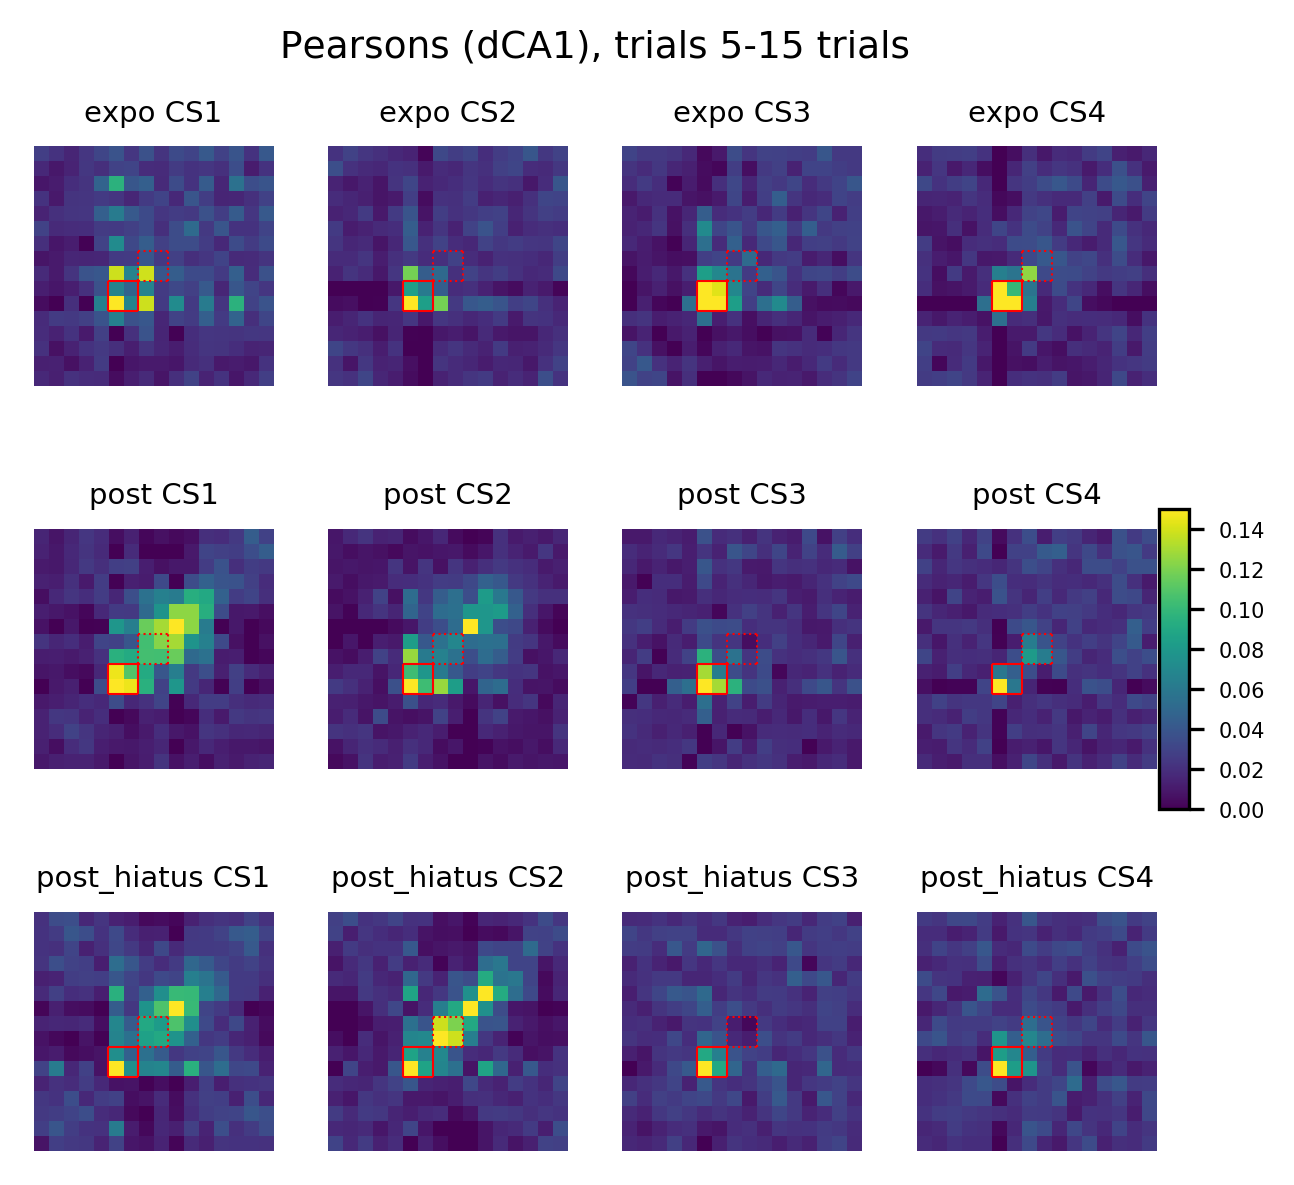

In [69]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,4))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("mid_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+" "+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

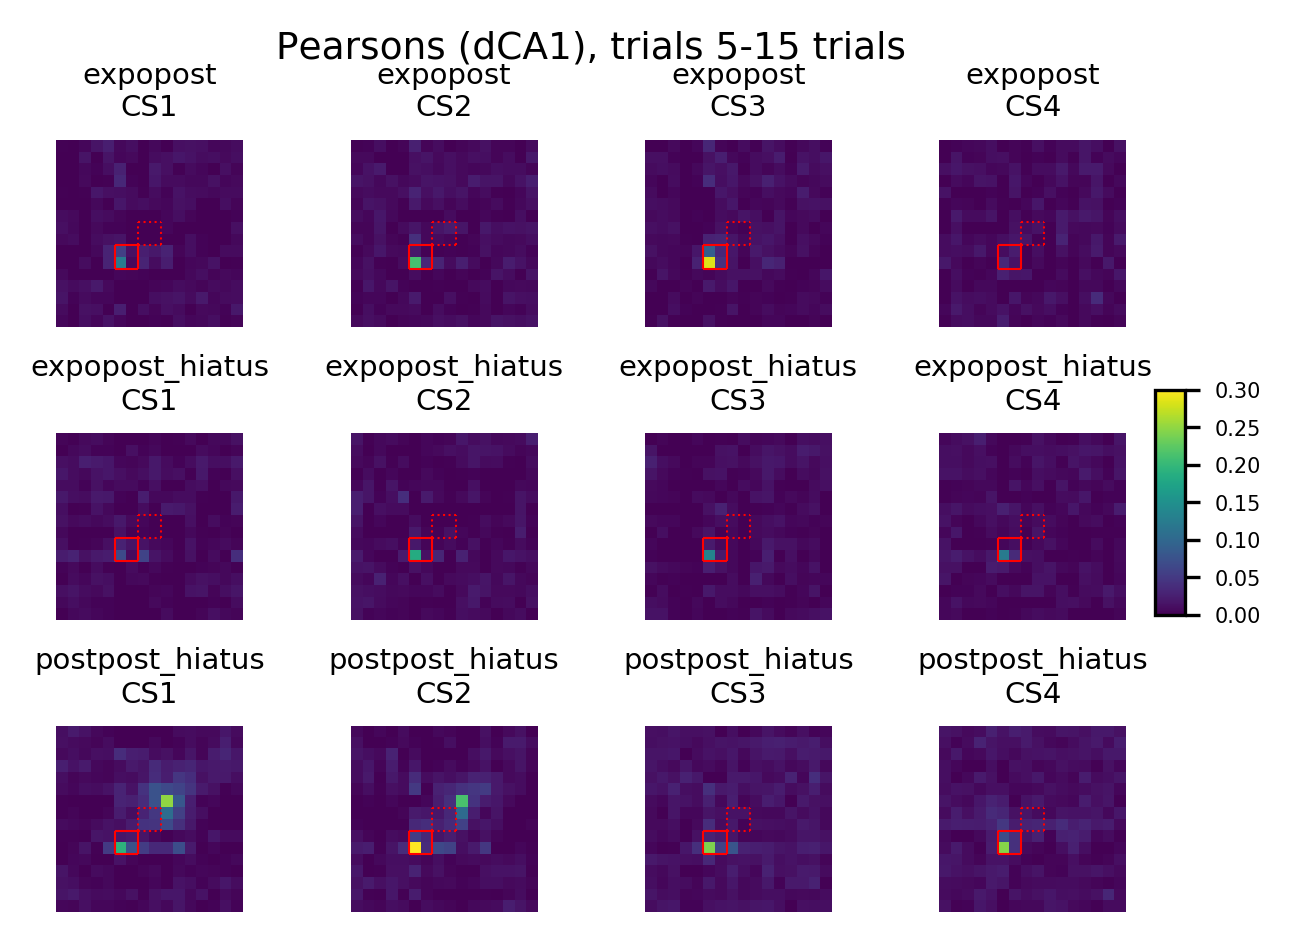

In [70]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,3))
for sess,r in zip(CR_comparisons,range(len(CR_comparisons))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("mid_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.3)
        axs[r][c].set_title(sess+"\n"+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

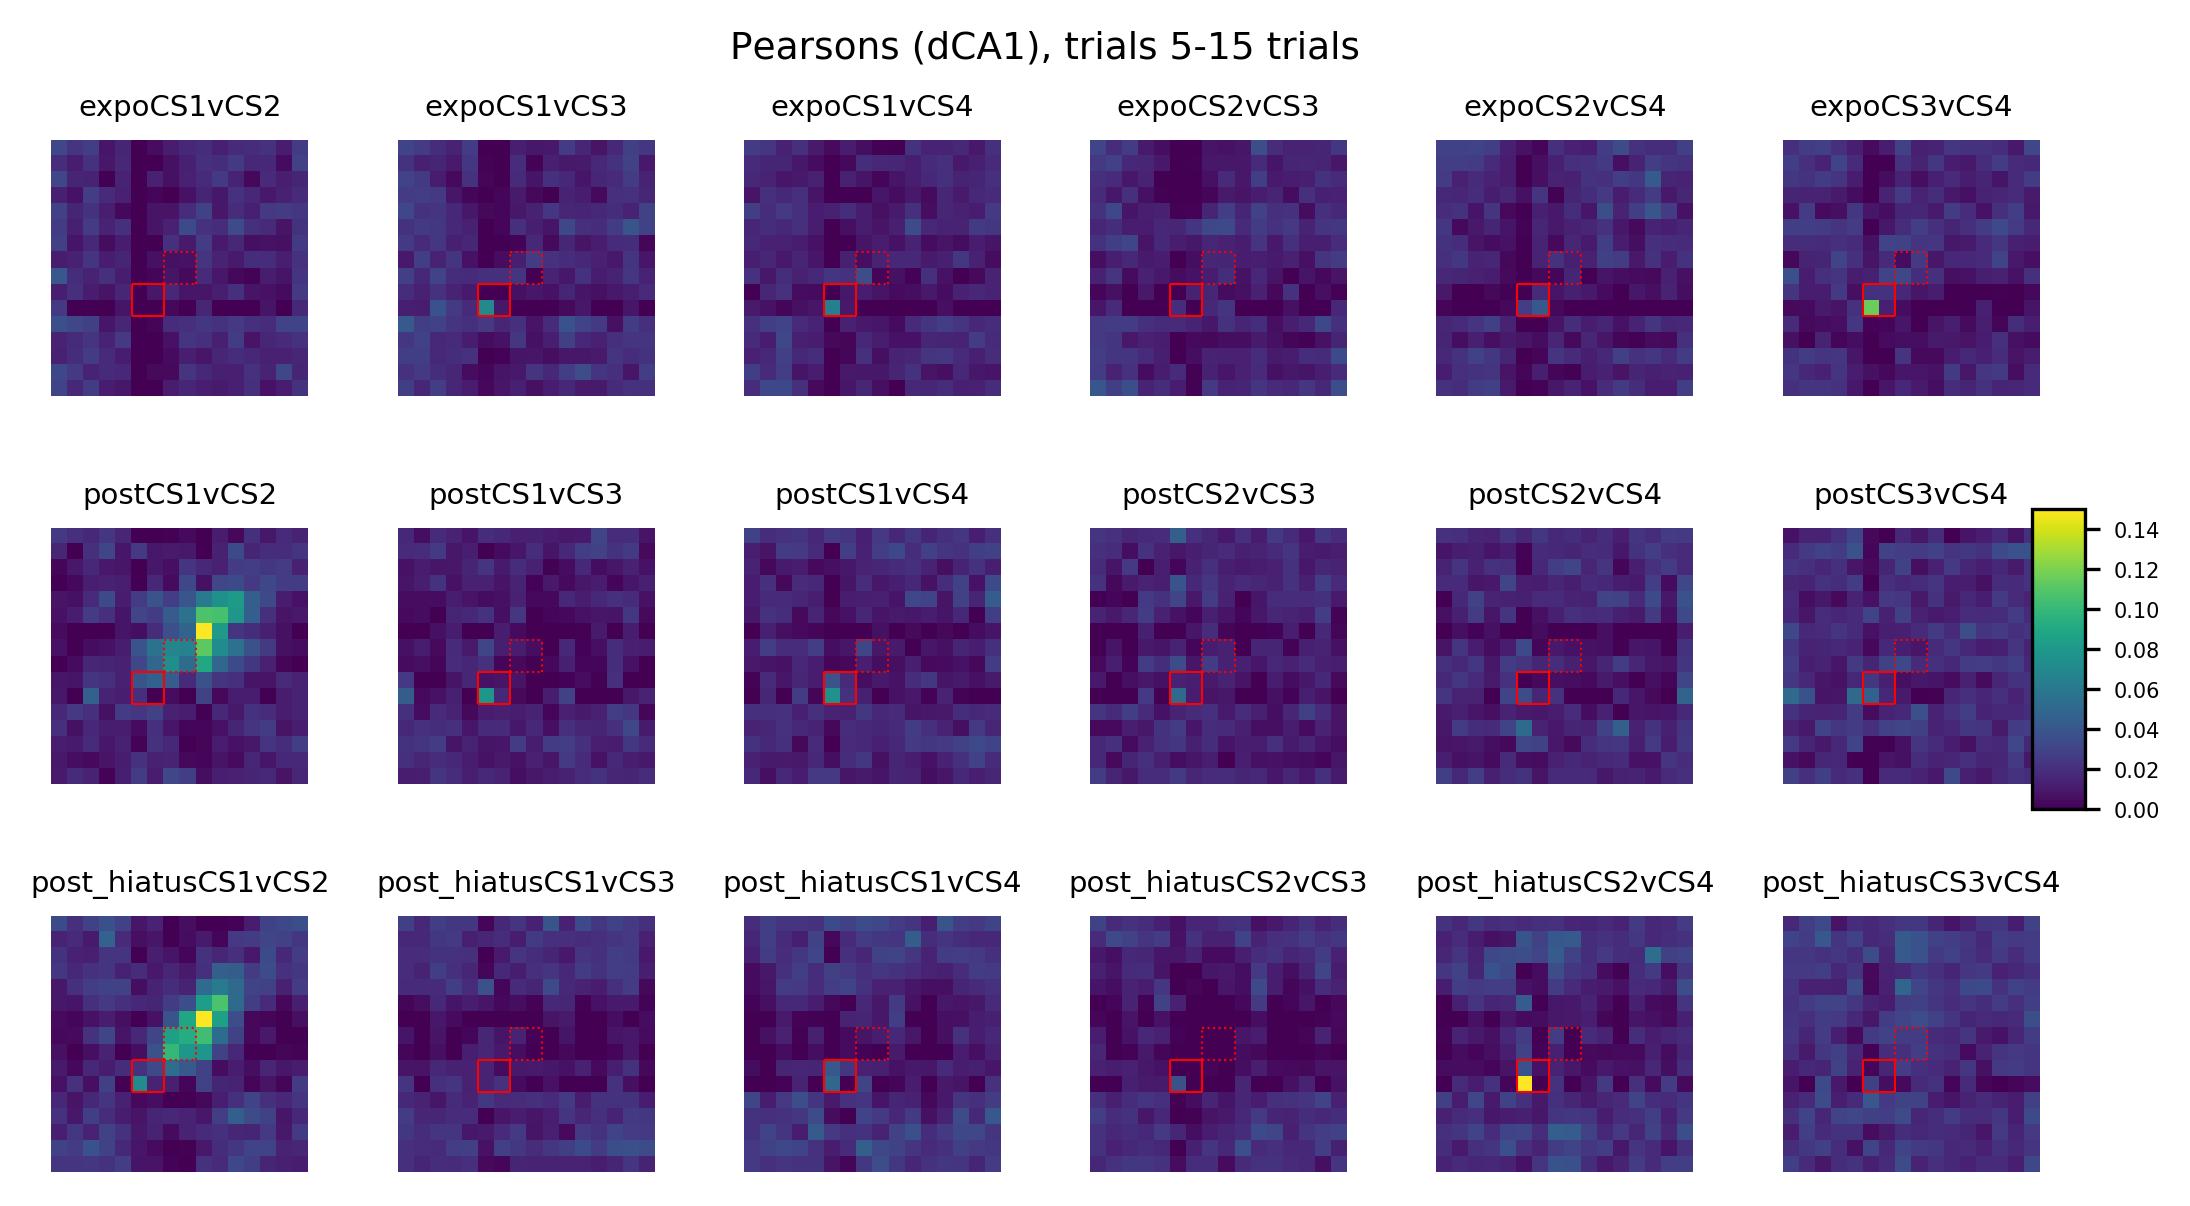

In [71]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,6,figsize=(7,4))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4'],[0,1,2,3,4,5]):
        im=axs[r][c].imshow(eval("mid_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

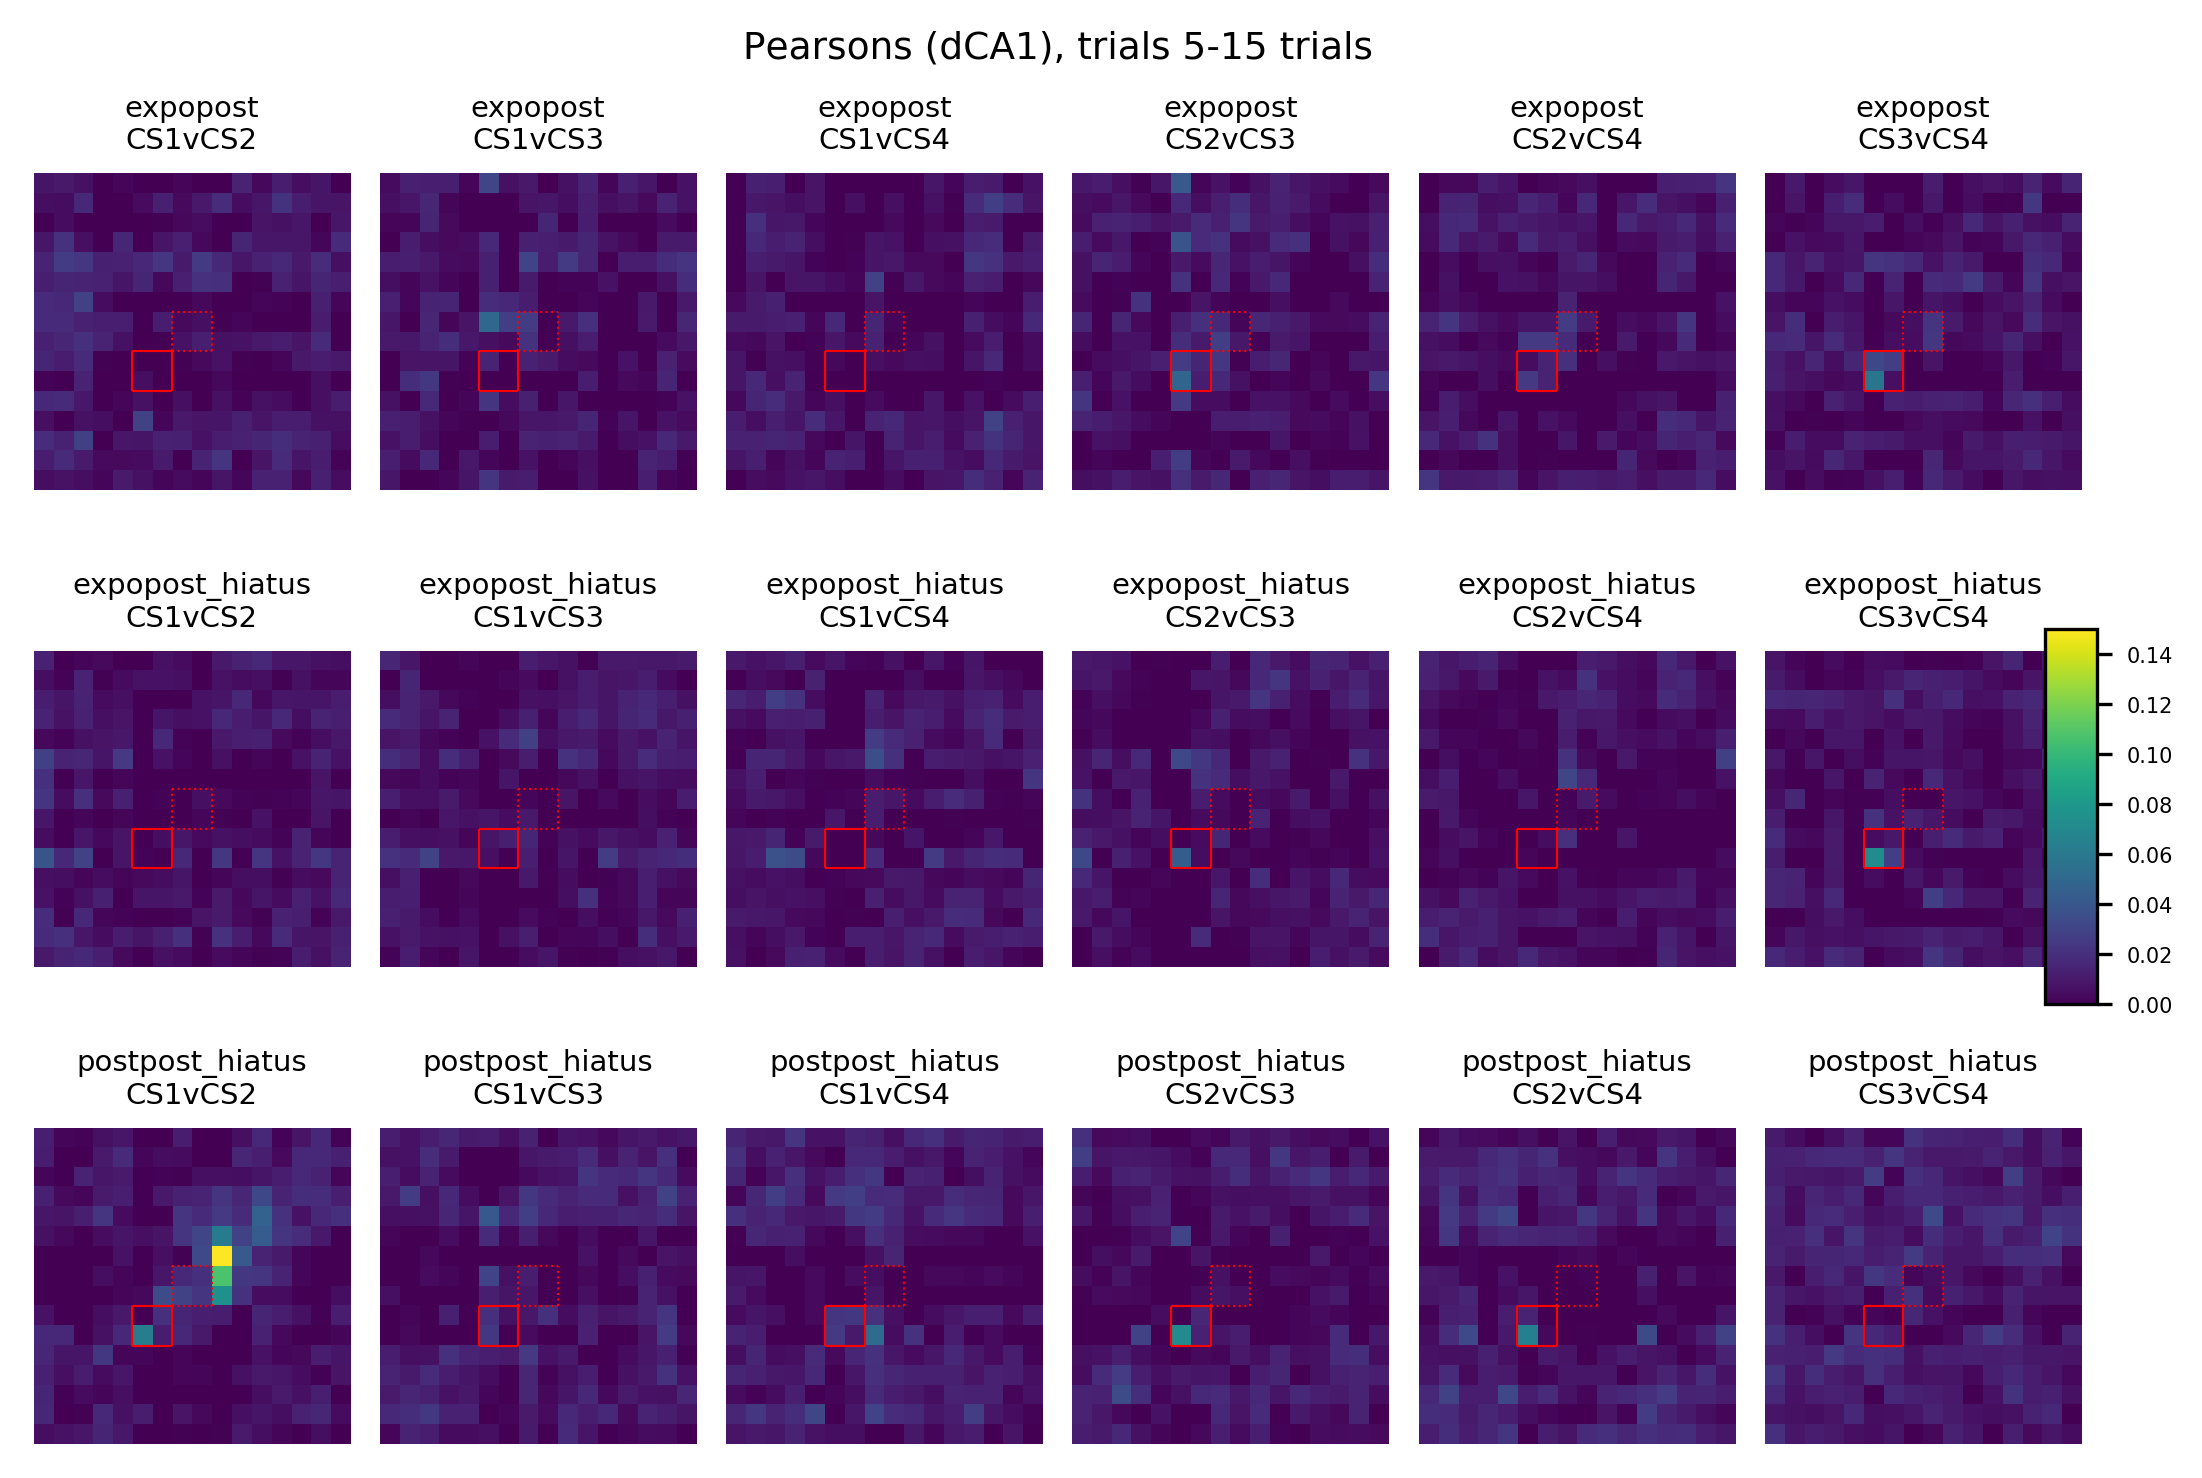

In [68]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,6,figsize=(7,5))
for sess,r in zip(CR_comparisons,range(len(CR_comparisons))):
    for trial,c in zip(['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4'],[0,1,2,3,4,5]):
        im=axs[r][c].imshow(eval("mid_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+"\n"+trial,fontsize=7)
        axs[r][c].vlines(4.5,4.5,6.5,color='r')
        axs[r][c].hlines(4.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,4.5,6.5,color='r')
        axs[r][c].hlines(6.5,4.5,6.5,color='r')
        axs[r][c].vlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(6.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].vlines(8.5,6.5,8.5,color='r',linestyle=':')
        axs[r][c].hlines(8.5,6.5,8.5,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

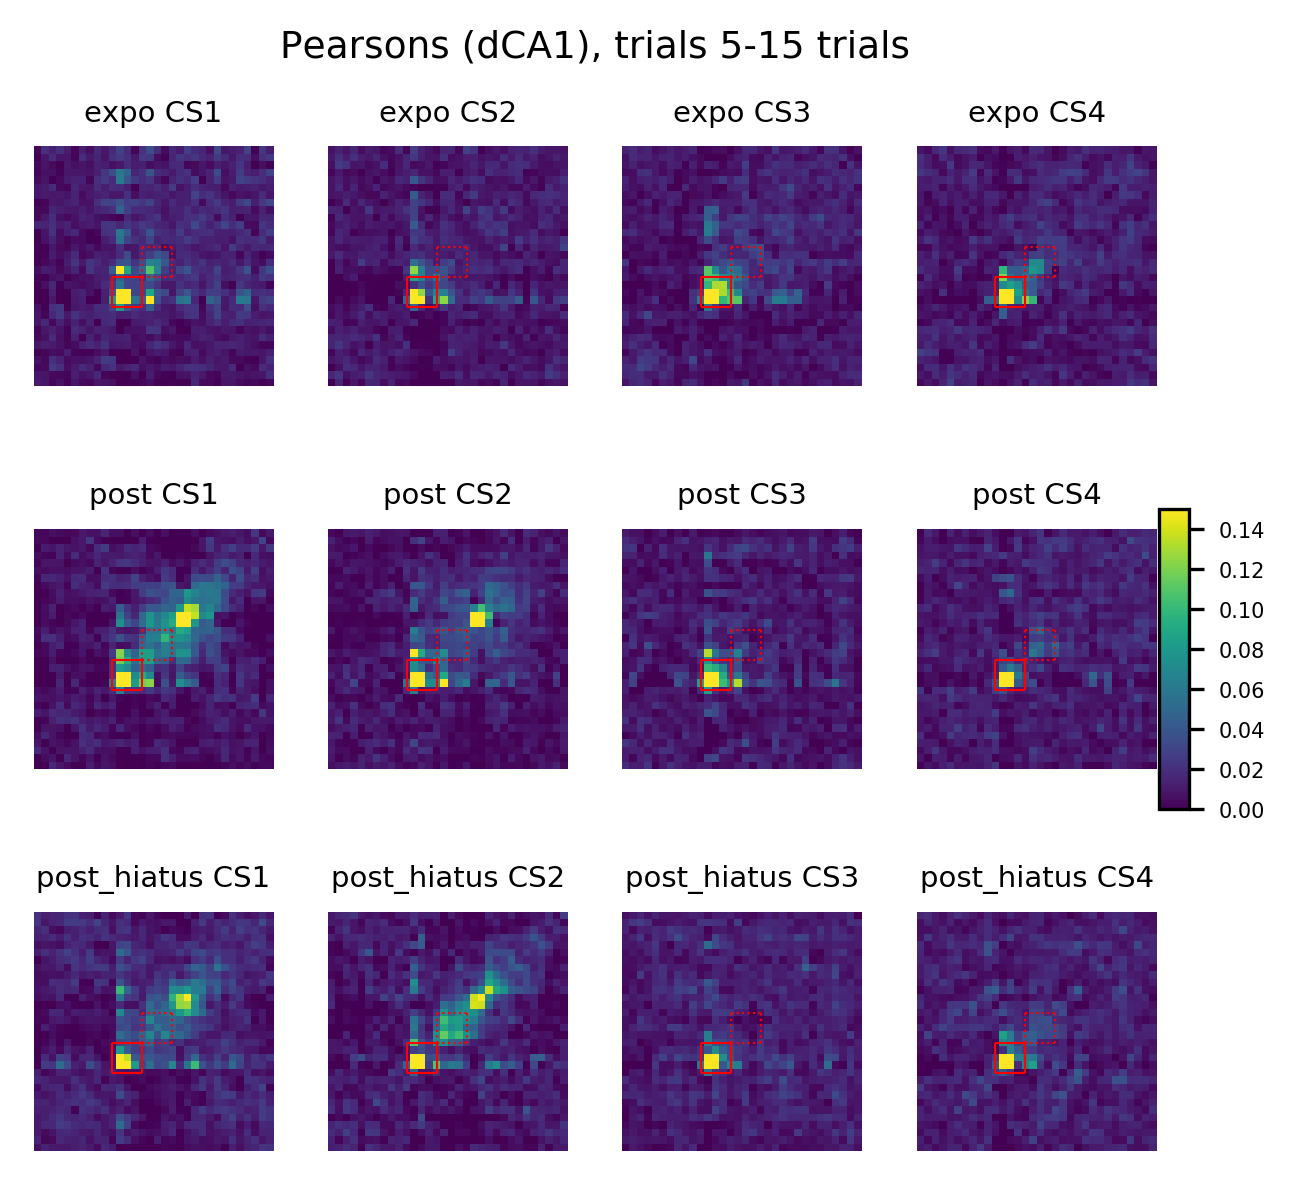

In [66]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,4))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("mid_big_matrix_05s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+" "+trial,fontsize=7)
        axs[r][c].vlines(10,10,14,color='r')
        axs[r][c].hlines(10,10,14,color='r')
        axs[r][c].vlines(14,10,14,color='r')
        axs[r][c].hlines(14,10,14,color='r')
        axs[r][c].vlines(14,14,18,color='r',linestyle=':')
        axs[r][c].hlines(14,14,18,color='r',linestyle=':')
        axs[r][c].vlines(18,14,18,color='r',linestyle=':')
        axs[r][c].hlines(18,14,18,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

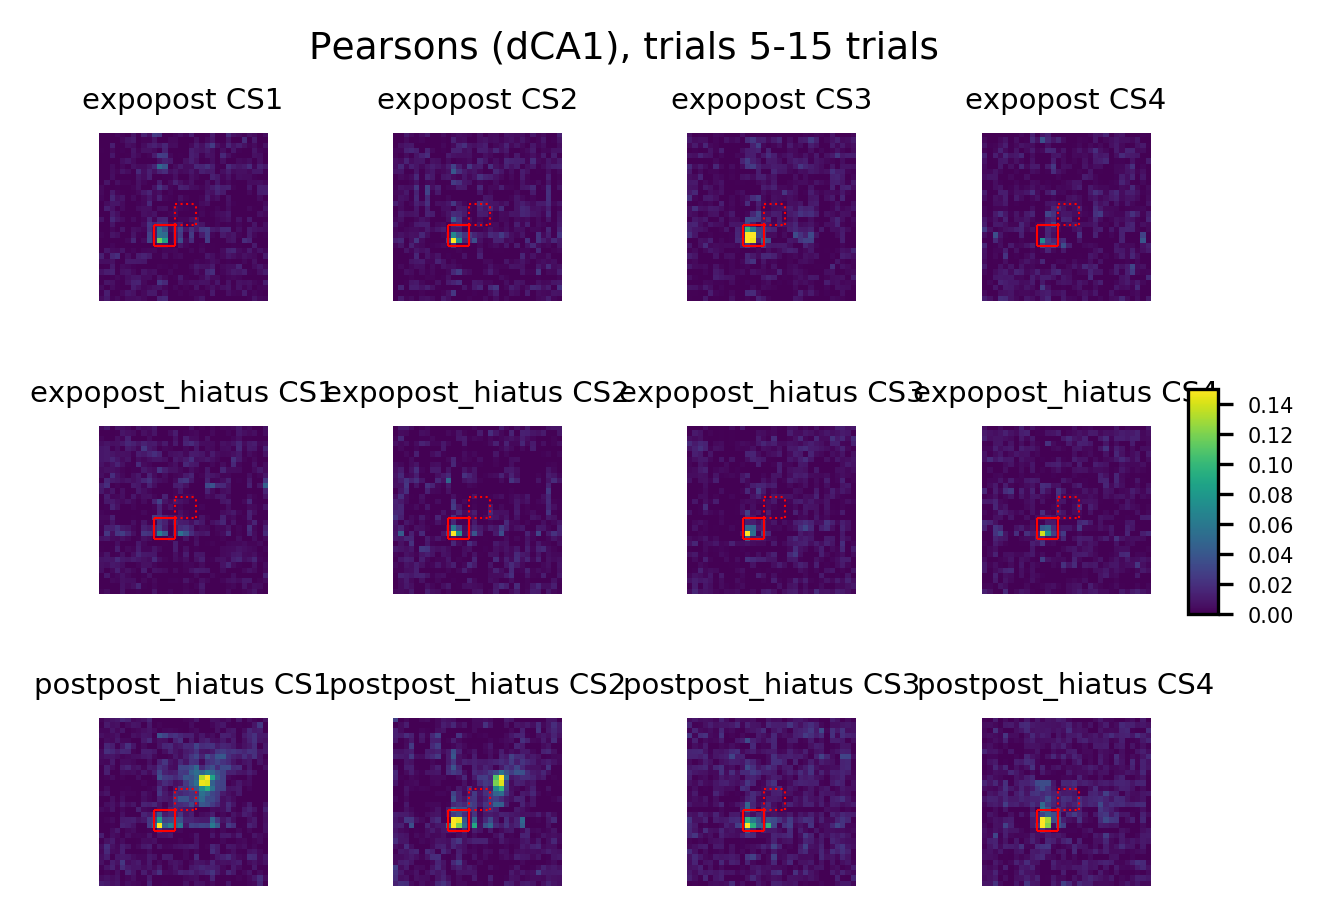

In [67]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(3,4,figsize=(4,3))
for sess,r in zip(CR_comparisons,range(len(CR_comparisons))):
    for trial,c in zip(['CS1','CS2','CS3','CS4'],[0,1,2,3]):
        im=axs[r][c].imshow(eval("mid_big_matrix_05s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.15)
        axs[r][c].set_title(sess+" "+trial,fontsize=7)
        axs[r][c].vlines(10,10,14,color='r')
        axs[r][c].hlines(10,10,14,color='r')
        axs[r][c].vlines(14,10,14,color='r')
        axs[r][c].hlines(14,10,14,color='r')
        axs[r][c].vlines(14,14,18,color='r',linestyle=':')
        axs[r][c].hlines(14,14,18,color='r',linestyle=':')
        axs[r][c].vlines(18,14,18,color='r',linestyle=':')
        axs[r][c].hlines(18,14,18,color='r',linestyle=':')
        pt.remove_axes(axs[r][c])
pl.suptitle('Pearsons (dCA1), trials 5-15 trials',y=1.01,fontsize=9)
cax = fig.add_axes([.97, 0.36, 0.025, 0.25])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

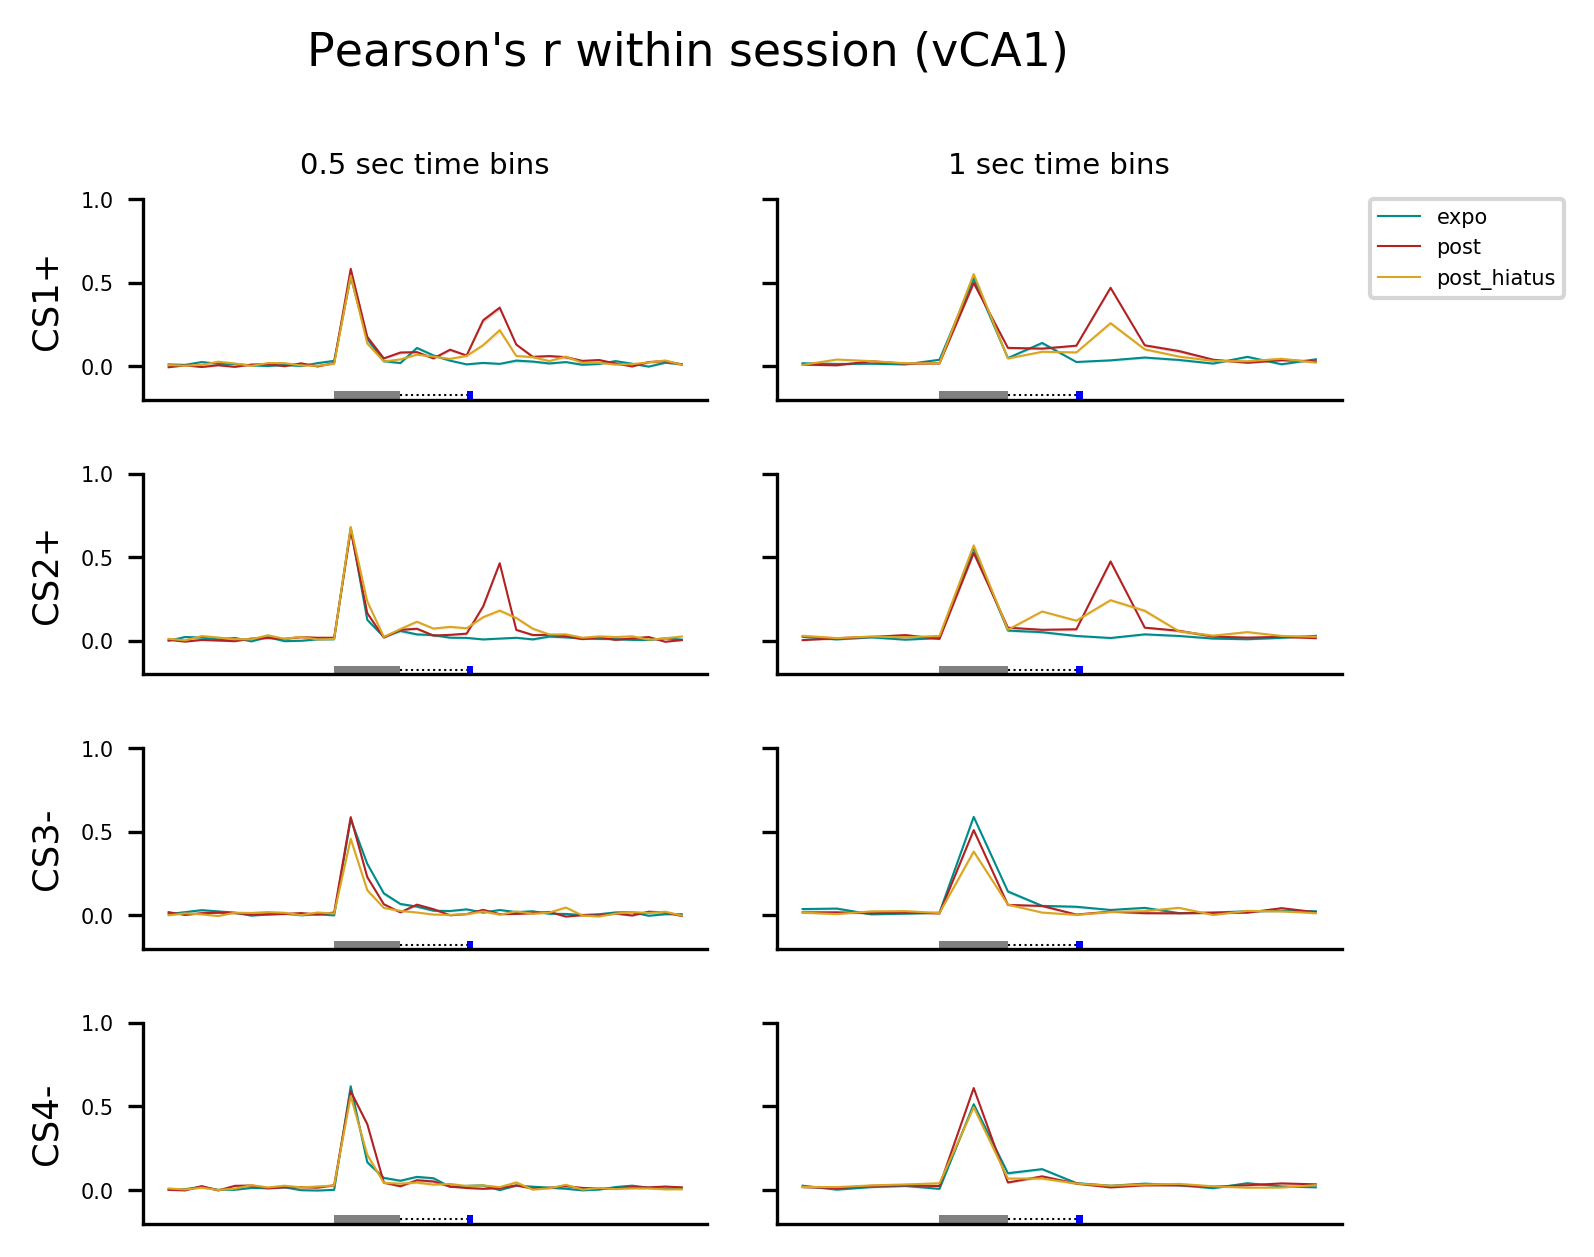

In [60]:
fig, ax = pl.subplots(4,2, figsize=(4.8, 4), sharey=True)

for x,odor in zip(range(len(odors)),odors):
    for sess,c,la in zip(sessions,['darkcyan','firebrick','goldenrod'],sessions):
        for y,tb,sub in zip(range(2),bins,[10,4]):
            ax[x][y].plot([(t-sub) for t in range(bin_ranges[y])],[eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])],
                            color =c,ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            s = np.array([eval("mid_matrix_%s_%s_%s_%s_err[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            ax[x][y].fill_between([(t-sub) for t in range(bin_ranges[y])],m-s,m+s,alpha=0.2,color=c,linewidth=0)  
for y,tick,tb in zip(range(2),[2,1],['0.5 sec','1 sec']):
    for x,odor in zip(range(len(odors)),['CS1+','CS2+','CS3-','CS4-']):
        ax[x][y].set_ylim(-0.2,1)
        #ax[x].set_xlim(-3, bin_ranges[x])
        #ax[x].set_xticks(np.arange(-2,11, 1))
        #ax[x].set_xticklabels(np.arange(-2,11, .5))
        #ax[x].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(odor,fontsize=8.5)
        pt.plot_period_bar(ax[x][y], -.2, start_end=(0, 2*tick), color='grey', delta_y=.05)
    # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[x][y], -.2, start_end=(4*tick, 4.2*tick), color='b', delta_y=.05)
        ax[x][y].hlines(-.2+.025, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[x][y].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title(tb+" time bins")
ax[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Pearson's r within session (dCA1)", fontsize=11, y=1.05)

fig.tight_layout(pad=3)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

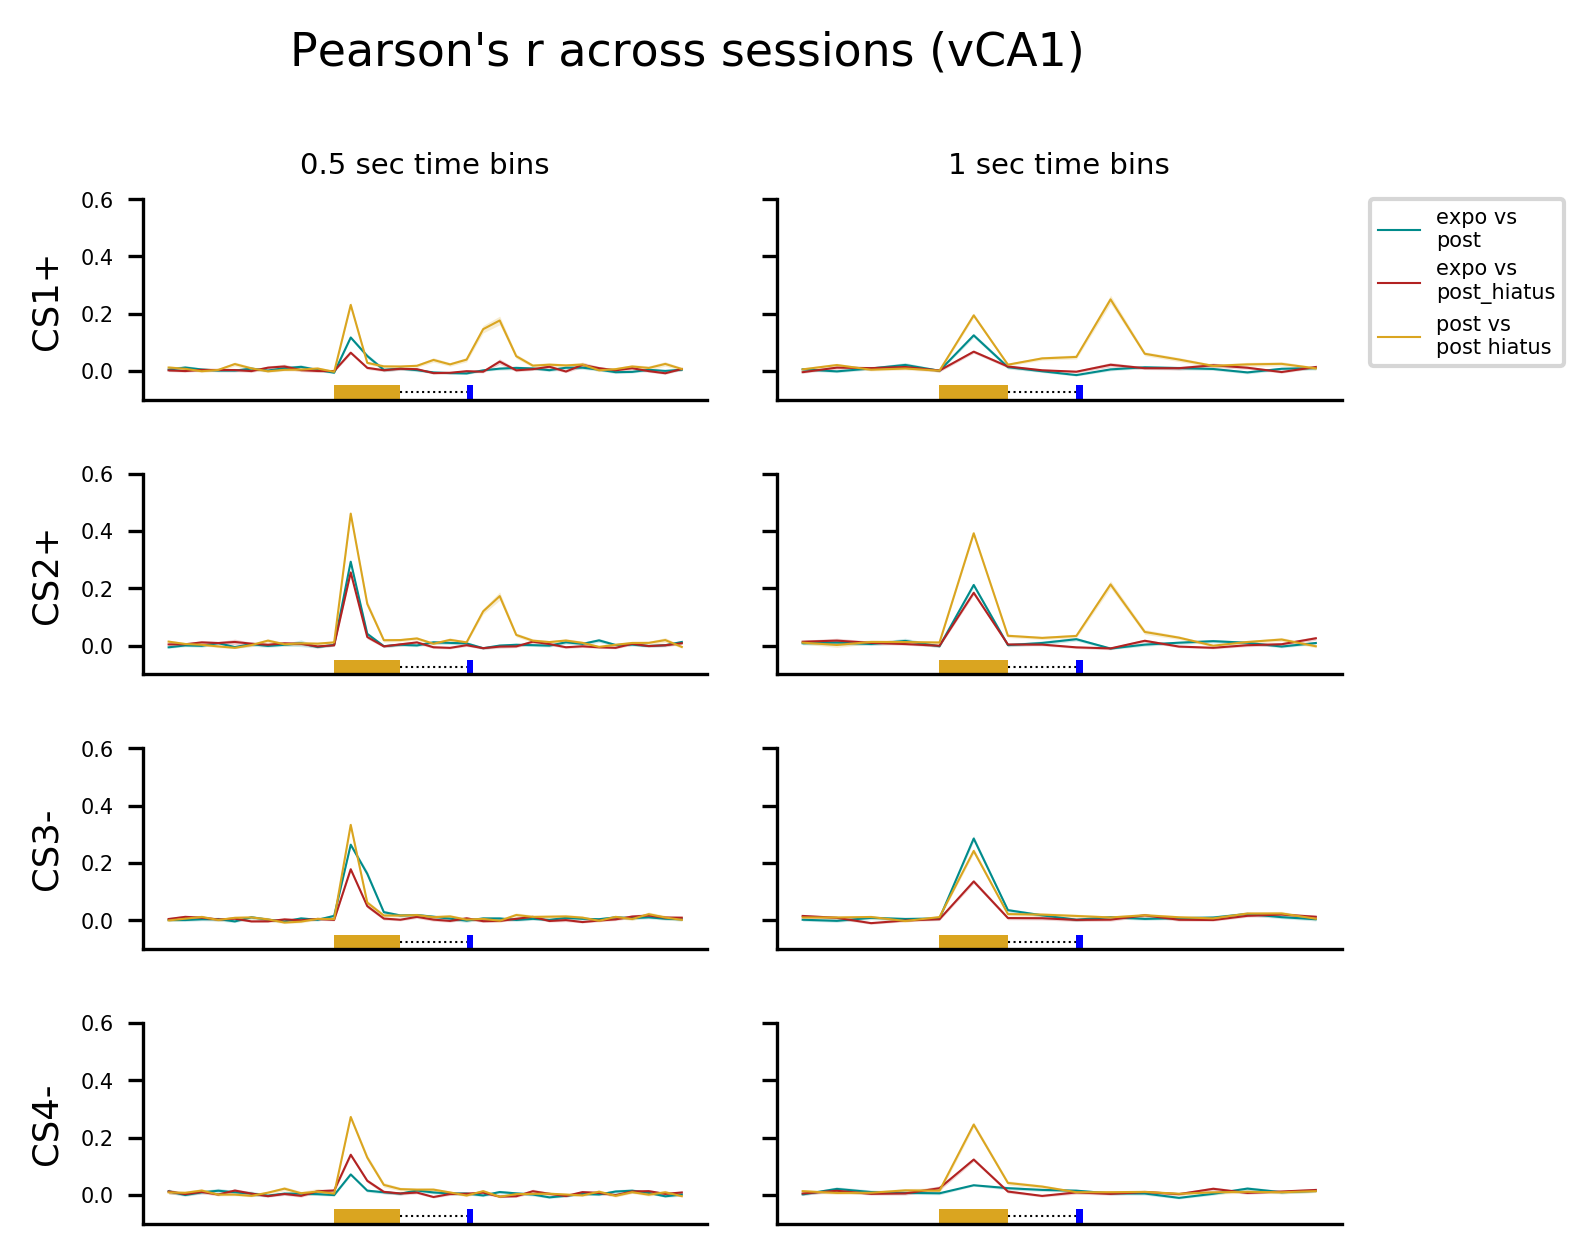

In [61]:
fig, ax = pl.subplots(4,2, figsize=(4.8, 4), sharey=True)

for x,odor in zip(range(len(odors)),odors):
    for sess,c,la in zip(CR_comparisons,['darkcyan','firebrick','goldenrod'],['expo vs\npost','expo vs\npost_hiatus','post vs\npost hiatus']):
        for y,tb,sub in zip(range(2),bins,[10,4]):
            ax[x][y].plot([(t-sub) for t in range(bin_ranges[y])],[eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])],
                            color =c,ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            s = np.array([eval("mid_matrix_%s_%s_%s_%s_err[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            ax[x][y].fill_between([(t-sub) for t in range(bin_ranges[y])],m-s,m+s,alpha=0.2,color=c,linewidth=0)  
for y,tick,tb in zip(range(2),[2,1],['0.5 sec','1 sec']):
    for x,odor in zip(range(len(odors)),['CS1+','CS2+','CS3-','CS4-']):
        ax[x][y].set_ylim(-0.1,.6)
        #ax[x].set_xlim(-3, bin_ranges[x])
        #ax[x].set_xticks(np.arange(-2,11, 1))
        #ax[x].set_xticklabels(np.arange(-2,11, .5))
        #ax[x].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(odor,fontsize=8.5)
        pt.plot_period_bar(ax[x][y], -.1, start_end=(0, 2*tick), color='goldenrod', delta_y=.05)
    # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[x][y], -.1, start_end=(4*tick, 4.2*tick), color='b', delta_y=.05)
        ax[x][y].hlines(-.1+.025, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[x][y].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title(tb+" time bins")
ax[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Pearson's r across sessions (dCA1)", fontsize=11, y=1.05)

fig.tight_layout(pad=3)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

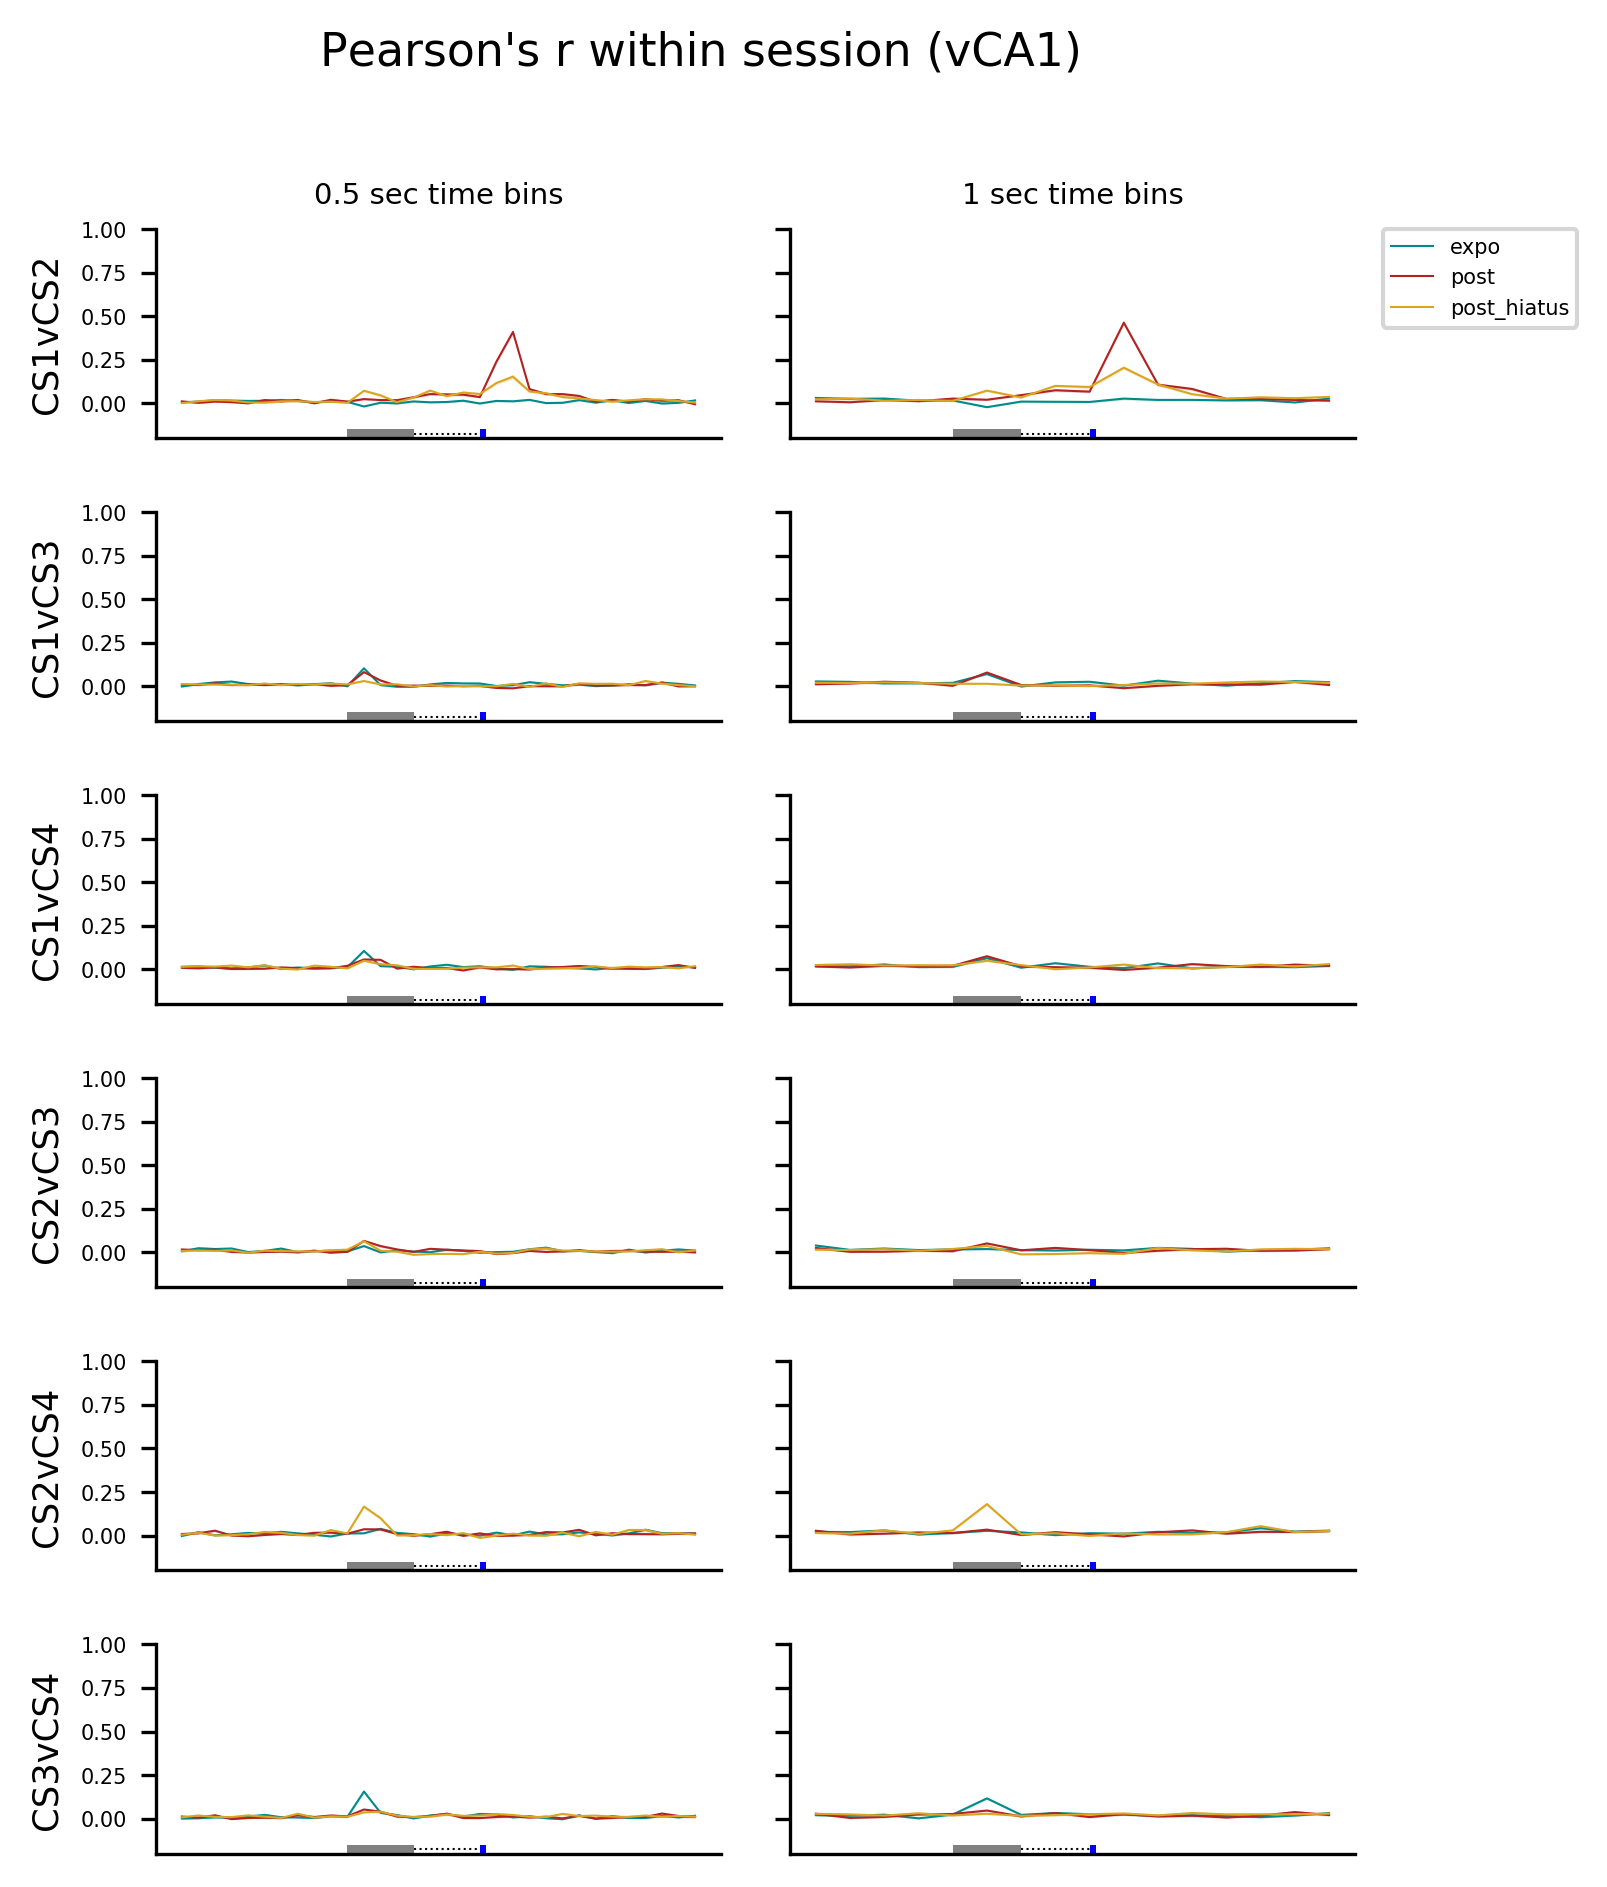

In [62]:
fig, ax = pl.subplots(6,2, figsize=(4.8, 6), sharey=True)

for x,odor in zip(range(6),['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']):
    for sess,c,la in zip(sessions,['darkcyan','firebrick','goldenrod'],sessions):
        for y,tb,sub in zip(range(2),bins,[10,4]):
            ax[x][y].plot([(t-sub) for t in range(bin_ranges[y])],[eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])],
                            color =c,ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            s = np.array([eval("mid_matrix_%s_%s_%s_%s_err[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            ax[x][y].fill_between([(t-sub) for t in range(bin_ranges[y])],m-s,m+s,alpha=0.2,color=c,linewidth=0)  
for y,tick,tb in zip(range(2),[2,1],['0.5 sec','1 sec']):
    for x,odor in zip(range(6),['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']):
        ax[x][y].set_ylim(-0.2,1)
        #ax[x].set_xlim(-3, bin_ranges[x])
        #ax[x].set_xticks(np.arange(-2,11, 1))
        #ax[x].set_xticklabels(np.arange(-2,11, .5))
        #ax[x].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(odor,fontsize=8.5)
        pt.plot_period_bar(ax[x][y], -.2, start_end=(0, 2*tick), color='grey', delta_y=.05)
    # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[x][y], -.2, start_end=(4*tick, 4.2*tick), color='b', delta_y=.05)
        ax[x][y].hlines(-.2+.025, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[x][y].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title(tb+" time bins")
ax[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Pearson's r within session (dCA1)", fontsize=11, y=1.05)

fig.tight_layout(pad=3)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

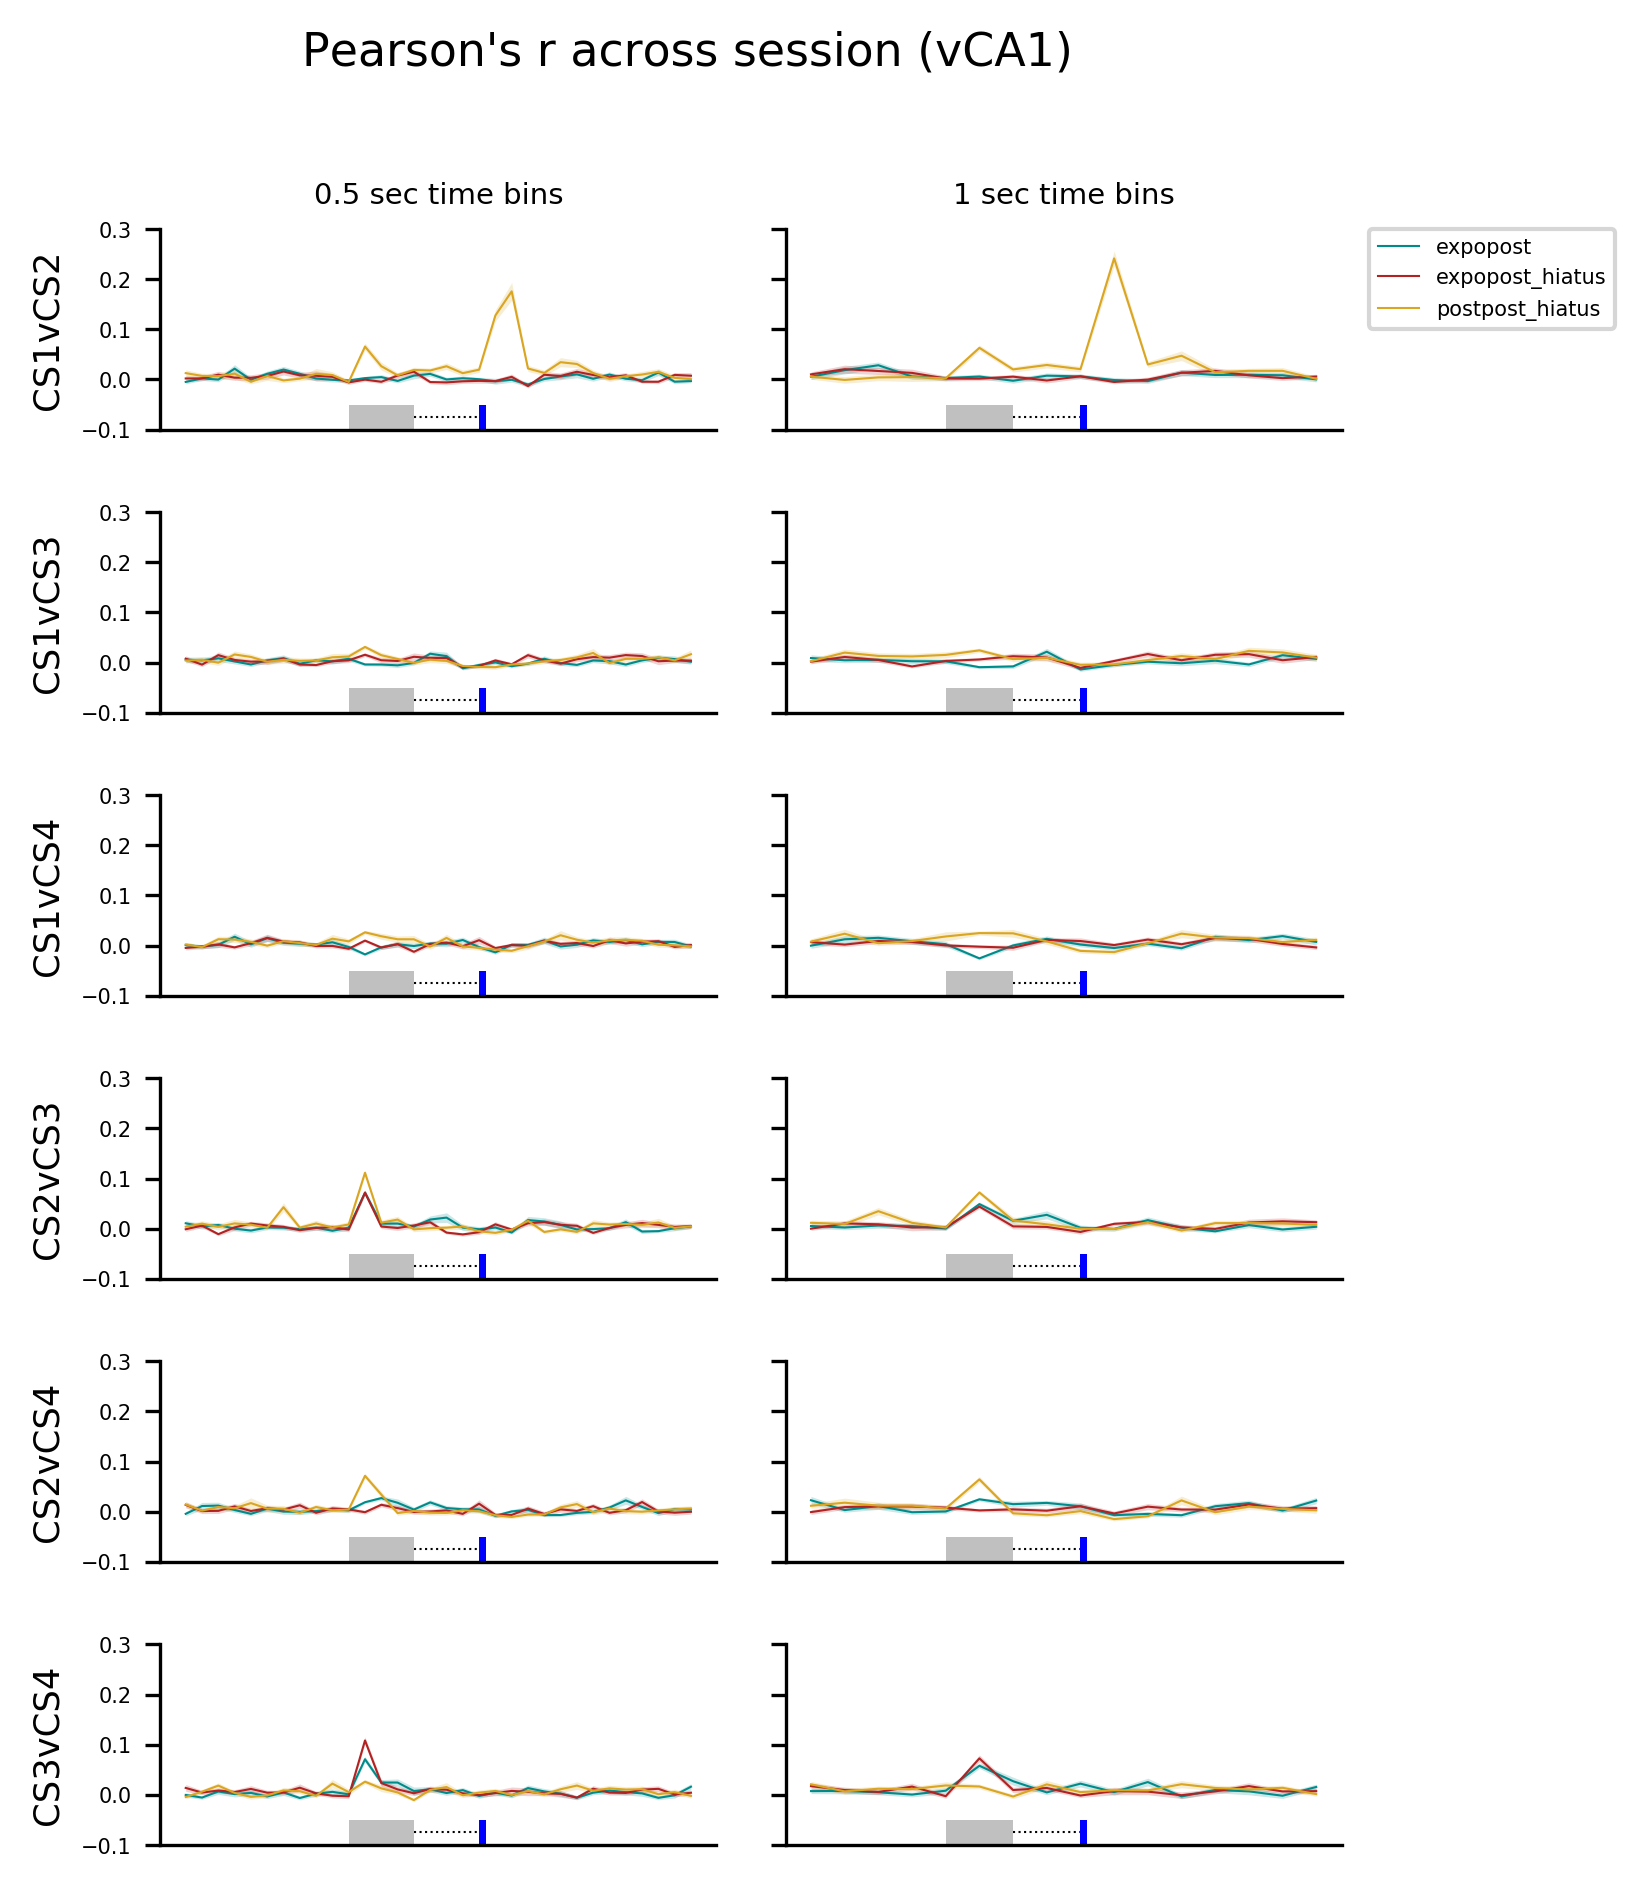

In [63]:
fig, ax = pl.subplots(6,2, figsize=(4.8, 6), sharey=True)

for x,odor in zip(range(6),['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']):
    for sess,c,la in zip(CR_comparisons,['darkcyan','firebrick','goldenrod'],CR_comparisons):
        for y,tb,sub in zip(range(2),bins,[10,4]):
            ax[x][y].plot([(t-sub) for t in range(bin_ranges[y])],[eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])],
                            color =c,ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([eval("mid_matrix_%s_%s_%s_%s[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            s = np.array([eval("mid_matrix_%s_%s_%s_%s_err[%s]"%(tb,sess,odor,t,t)) for t in range(bin_ranges[y])])
            ax[x][y].fill_between([(t-sub) for t in range(bin_ranges[y])],m-s,m+s,alpha=0.2,color=c,linewidth=0)  
for y,tick,tb in zip(range(2),[2,1],['0.5 sec','1 sec']):
    for x,odor in zip(range(6),['CS1vCS2','CS1vCS3','CS1vCS4','CS2vCS3','CS2vCS4','CS3vCS4']):
        ax[x][y].set_ylim(-0.1,.3)
        #ax[x].set_xlim(-3, bin_ranges[x])
        #ax[x].set_xticks(np.arange(-2,11, 1))
        #ax[x].set_xticklabels(np.arange(-2,11, .5))
        #ax[x].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(odor,fontsize=8.5)
        pt.plot_period_bar(ax[x][y], -.1, start_end=(0, 2*tick), color='silver', delta_y=.05)
    # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[x][y], -.1, start_end=(4*tick, 4.2*tick), color='b', delta_y=.05)
        ax[x][y].hlines(-.1+.025, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[x][y].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title(tb+" time bins")
ax[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Pearson's r across session (dCA1)", fontsize=11, y=1.05)

fig.tight_layout(pad=3)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

In [64]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'math'. Skipping...
Could not store variable 'os'. Skipping...
